In [4]:
pip install cufflinks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67895 sha256=6d72f7fc60f6bdb42c8f31059cc1ac0bf2405972a0dd20dff2c4808316e8e27b
  Stored in directory: /root/.cache/pip/wheels/09/8a/6b/cbe3e87b2e59bb5f90b49b034ce36b80b46a4d6e38444c34de
Successfully built cufflinks


# **Reducing Food Waste in Supermarkets with Smarter Inventory**

**Overview**
This project helps supermarkets reduce food waste by predicting daily demand for perishable items, ensuring optimal stock levels and minimizing unsold goods.

**Why It Matters**
Reducing waste saves resources and supports sustainability. By helping supermarkets stock only what’s needed, our project benefits both the environment and customers.

**Problem Statement**
Supermarkets often overstock or understock perishables, leading to waste or shortages. Our predictive model uses sales data of Rossmann Sales data

**Dataset**
The Rossmann Store Sales dataset is a public dataset, which contains daily historical sales data for 3 Rossmann stores from the 1st January 2013 till the 31st July 2015.

In [5]:
# Loading packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import datetime as dt # for date and time manipulation

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # data visualization
init_notebook_mode(connected=True)

import cufflinks as cf #  to call plots directly off of a pandas dataframe
cf.go_offline()

# 1. Exploratory Data Analysis and Visualization

In [6]:
# Loading dataset train, test and store
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
store=pd.read_csv('./store.csv')

<ipython-input-6-00c3d5b53471>:2: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [7]:
# Looking into each dataset size
print('training dataset shape',train.shape)
print('testing dataset shape',test.shape)
print('store dataset shape',store.shape)

training dataset shape (1017209, 9)
testing dataset shape (41088, 8)
store dataset shape (1115, 10)


In [8]:
# train dataset
train.head(3)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1

In [9]:
# test dataset
test.head(3)

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0

In [10]:
# store dataset
store.head(3)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct

In [11]:
# Samples having 0 sales
print('Sample having 0 sales :',train[train['Sales']<=0].shape,'\n')
print('Store Open : 1,','Store Closed : 0')
print(train['Open'].value_counts(),'\n')
print('Sample having closed store and sale is 0 :',train[(train['Sales']<=0)&(train['Open']==0)].shape)

Sample having 0 sales : (172871, 9) 

Store Open : 1, Store Closed : 0
Open
1    844392
0    172817
Name: count, dtype: int64 

Sample having closed store and sale is 0 : (172817, 9)


In [12]:
# making new train dataset having sales greater than zero
train=train[train['Sales']>0]
print('New training dataset shape',train.shape)

New training dataset shape (844338, 9)


In [13]:
# basic information about columns of train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844338 non-null  int64 
 1   DayOfWeek      844338 non-null  int64 
 2   Date           844338 non-null  object
 3   Sales          844338 non-null  int64 
 4   Customers      844338 non-null  int64 
 5   Open           844338 non-null  int64 
 6   Promo          844338 non-null  int64 
 7   StateHoliday   844338 non-null  object
 8   SchoolHoliday  844338 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 64.4+ MB


* Date column having date information but is of object type, so have to convert into datetime format
* Dataset does not cantain any missing values

In [14]:
# Converting into datetime format
train['Date']=pd.to_datetime(train['Date'])
train.sort_values(by='Date',ascending=True,inplace=True)
train.reset_index(inplace=True)
train.drop('index',axis=1,inplace=True)

# Start date record in dataset
start_date=train['Date'][0]
print('Start date :',start_date)

# End date record in dataset
end_date=train['Date'][844337]
print('End date :',end_date)

Start date : 2013-01-01 00:00:00
End date : 2015-07-31 00:00:00


In [15]:
# unique values of categorical columns
for i in ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']:
    print( i+':',train[i].unique())

DayOfWeek: [2 3 4 5 6 7 1]
Open: [1]
Promo: [0 1]
StateHoliday: ['a' '0' 'b' 'c' 0]
SchoolHoliday: [1 0]


* Open column having only 1 value so no need of this column
* StateHoliday column having two identical values but in different format so need to deal with this

In [16]:
# Droping 'Open' column and making correction in 'StateHoliday' column
index=train[train['StateHoliday']==0].index
train['StateHoliday'][index]='0'
train['StateHoliday'].value_counts()
train.drop('Open',axis=1,inplace=True)

# Note : I have converted numeric into string format in StateHoliday column because majority of variables are in string format

<ipython-input-16-1ff880731bfc>:3: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [17]:
# Checking for negative values
pd.options.display.float_format = '{:.0f}'.format # in order to round up the numbers
train.describe()

Store  DayOfWeek                           Date  Sales  Customers  \
count 844338     844338                         844338 844338     844338   
mean     558          4  2014-04-11 01:08:38.729702656   6956        763   
min        1          1            2013-01-01 00:00:00     46          8   
25%      280          2            2013-08-16 00:00:00   4859        519   
50%      558          3            2014-03-31 00:00:00   6369        676   
75%      837          5            2014-12-11 00:00:00   8360        893   
max     1115          7            2015-07-31 00:00:00  41551       7388   
std      322          2                            NaN   3104        401   

       Promo  SchoolHoliday  
count 844338         844338  
mean       0              0  
min        0              0  
25%        0              0  
50%        0              0  
75%        1              0  
max        1              1  
std        0              0

* We don't have negative values in dataset, therefore dataset is very clean

### 1.1 Visualization based on Days of Week

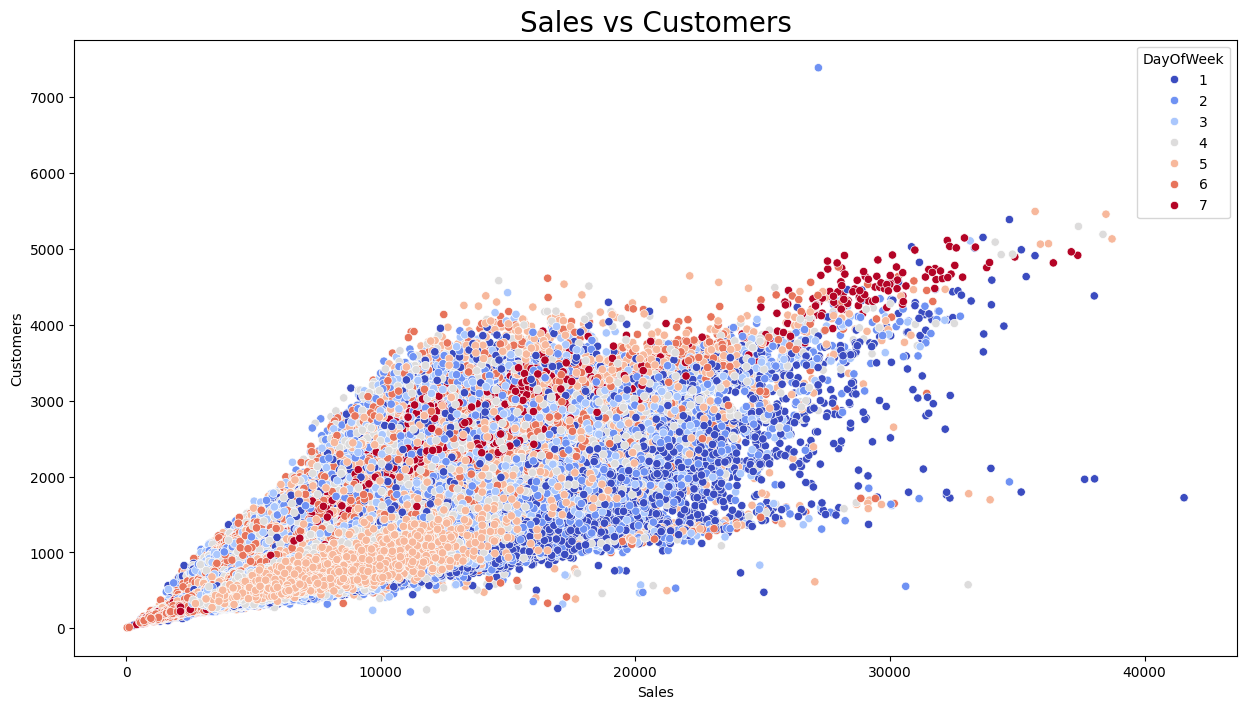

In [18]:
 # Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='DayOfWeek',palette='coolwarm')
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

DayOfWeek
6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: count, dtype: int64


<ipython-input-19-76c4f05c39fe>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




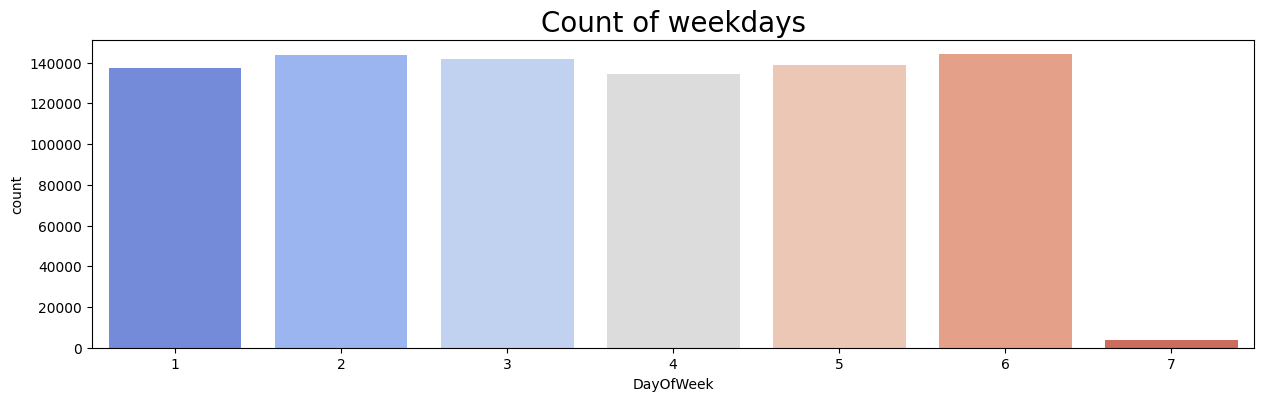

In [19]:
# Count of Weekdays
plt.figure(figsize=(15,4))
print(train['DayOfWeek'].value_counts())
sns.countplot(x='DayOfWeek',data=train,palette='coolwarm')
plt.title('Count of weekdays',fontdict={'fontsize':20})
plt.show()

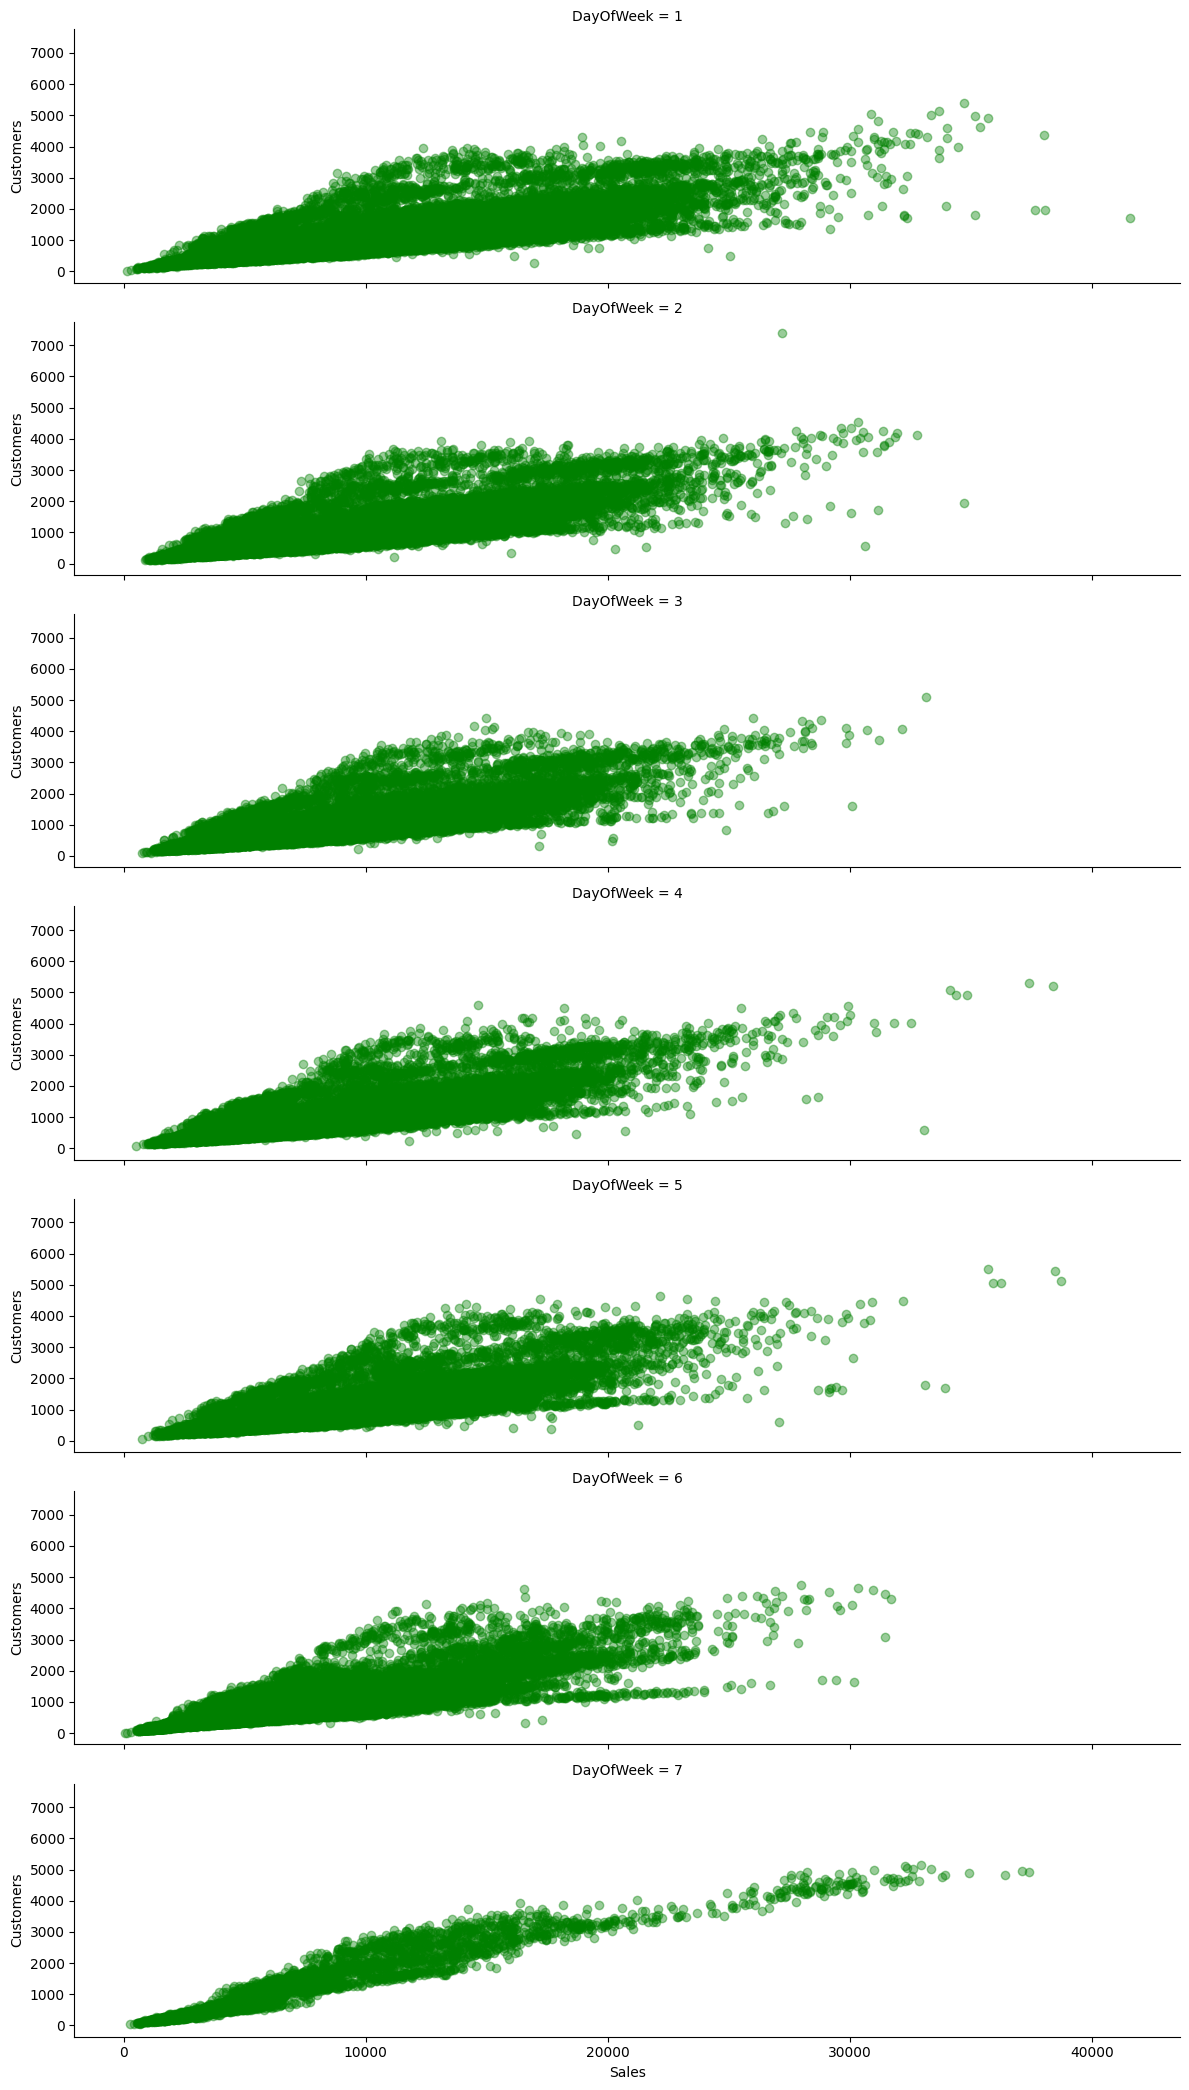

In [20]:
# Weekdays wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='DayOfWeek',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='green',alpha=0.4)
plt.show()

<ipython-input-21-489fbd6217c3>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




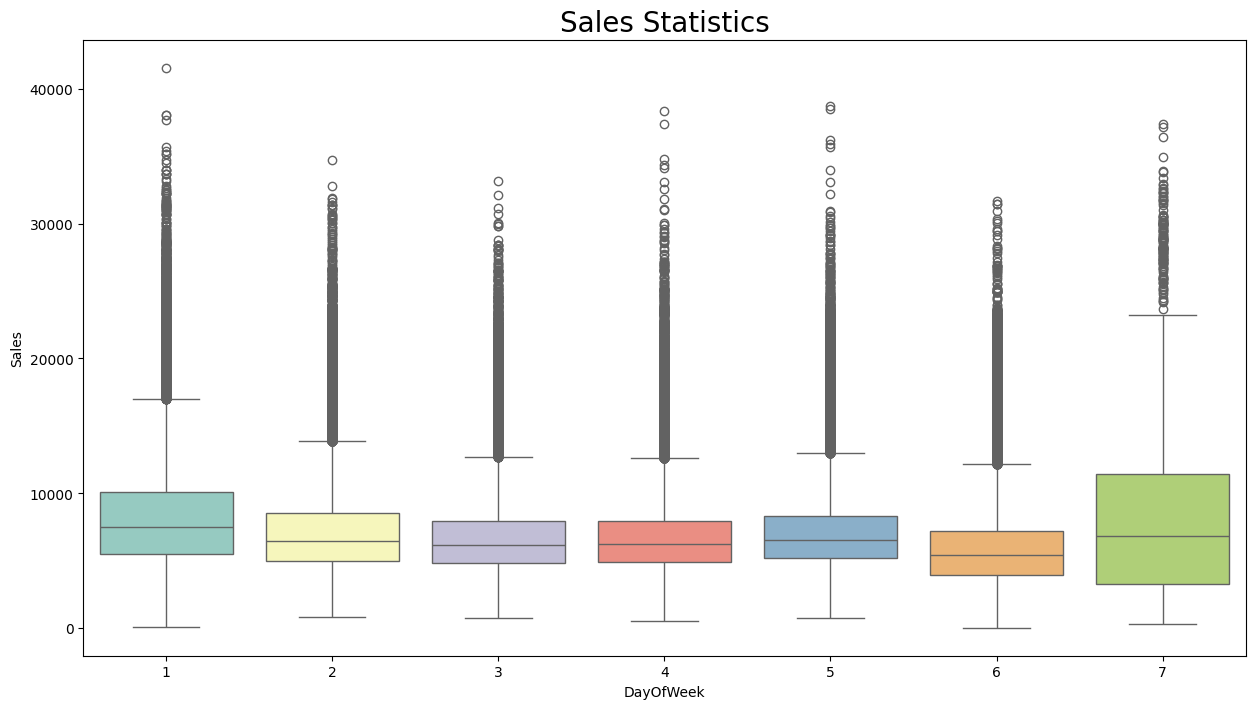

In [21]:
# Boxplot - "Sales"
plt.figure(figsize=(15,8))
sns.boxplot(y='Sales',x='DayOfWeek',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

<ipython-input-22-9a60578923a4>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




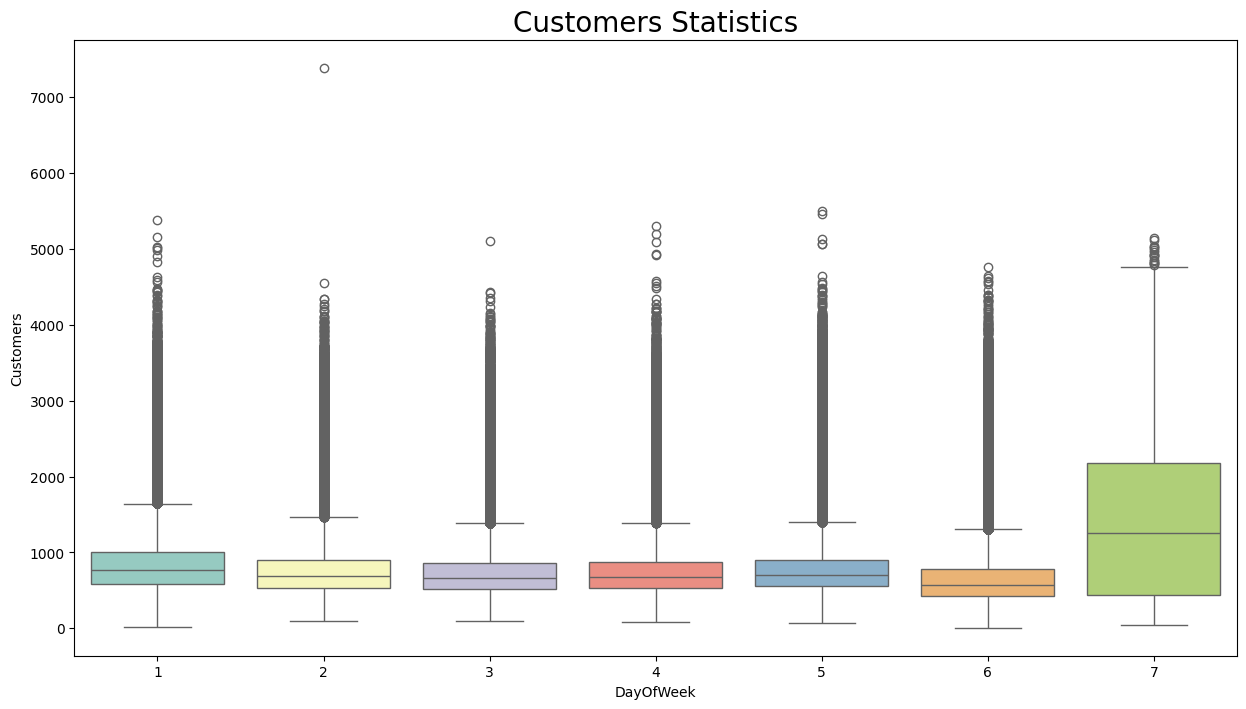

In [22]:
# Boxplot - "Customers"
plt.figure(figsize=(15,8))
sns.boxplot(y='Customers',x='DayOfWeek',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* The 7th day of week has very less variability as compare to other days of week
* The count of 7th days is very less as compare to other days but the average sales and average number of customers are pretty much high. One possible reason could be on sunday customers comes for a specific commodity as an essential need for survival

### 1.2 Visualization based on running Promo

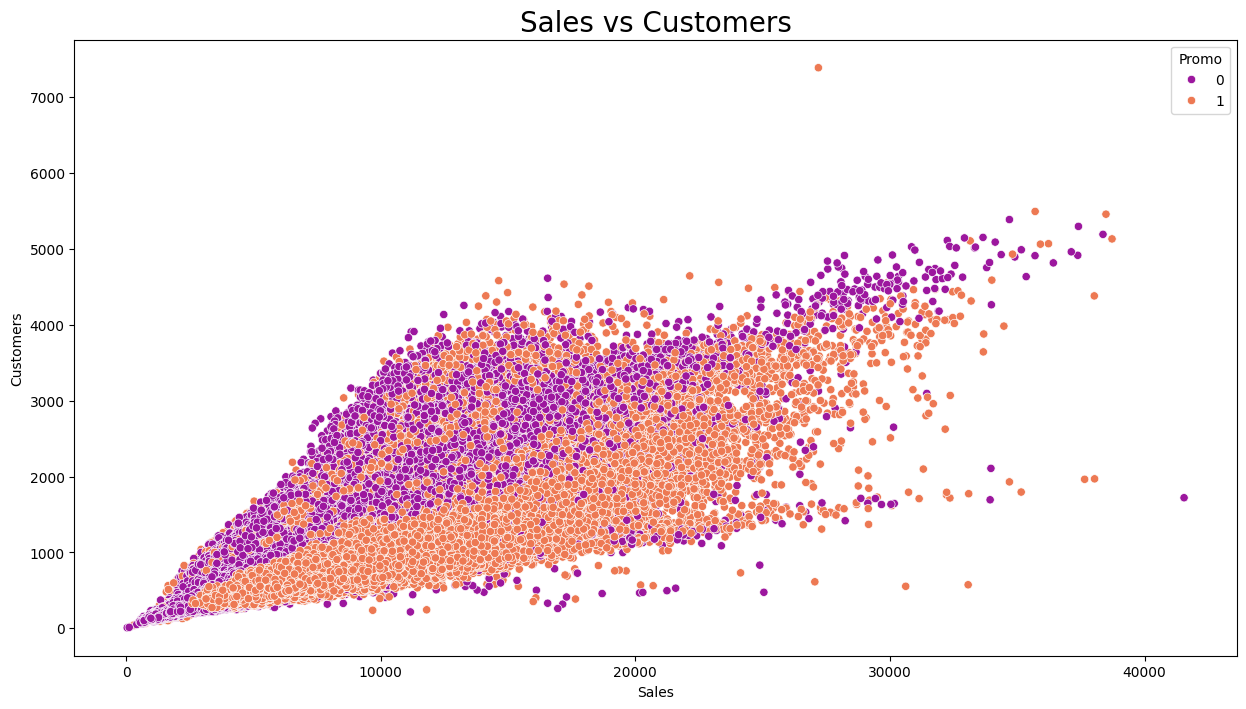

In [23]:
# Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='Promo',palette='plasma')
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

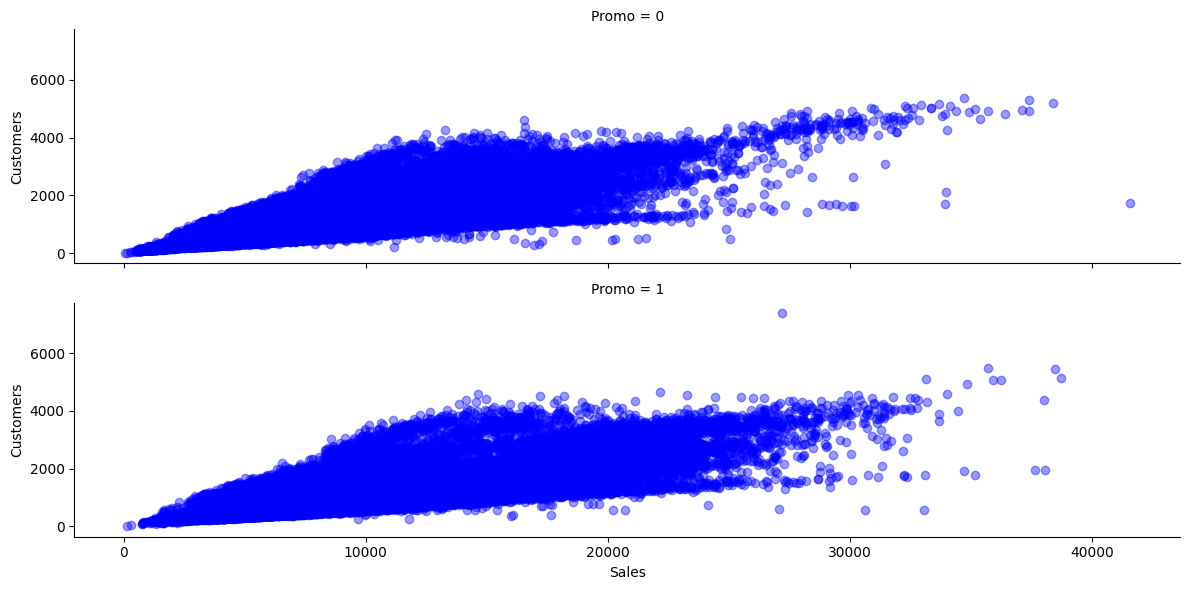

In [24]:
# Promo wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='Promo',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='blue',alpha=0.4)
plt.show()

<ipython-input-25-84137b397c13>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




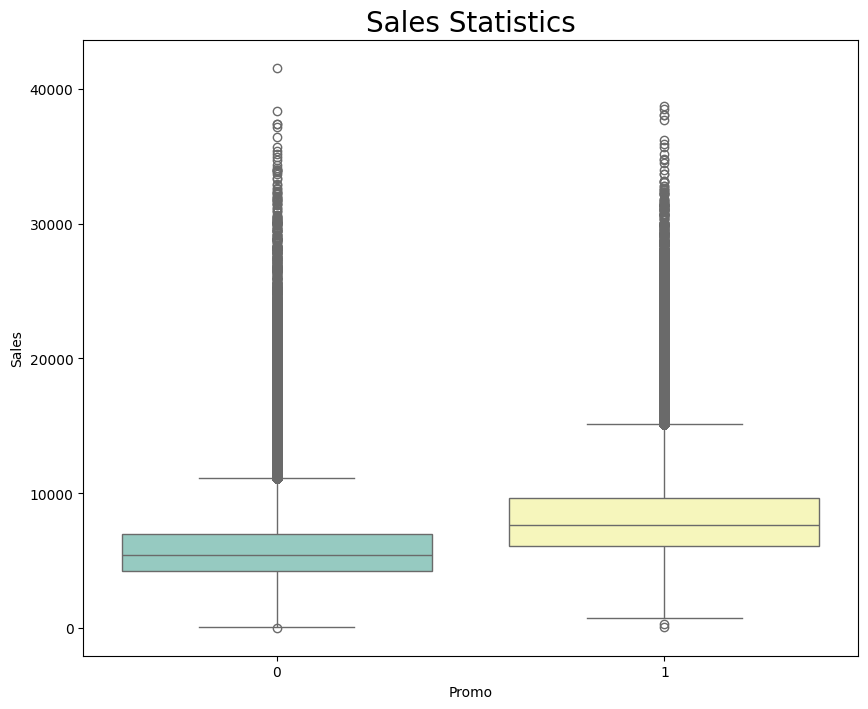

In [25]:
# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='Promo',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

<ipython-input-26-20861c7cec23>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




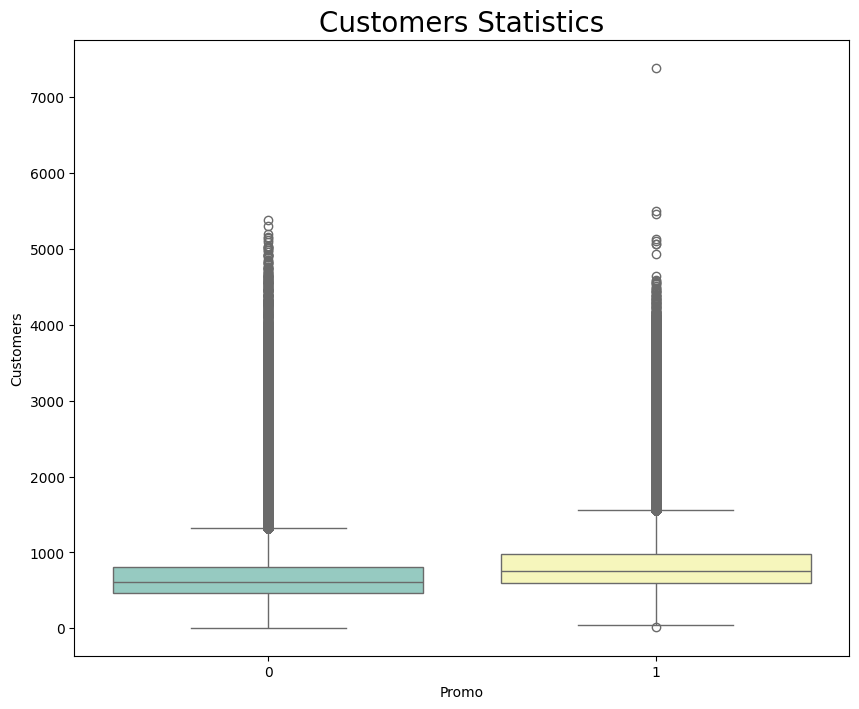

In [26]:
# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='Promo',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* There is much difference in sale before and after running Promo. It indicates that promo have done a great job in increasing the sale
* Not much noticable difference is seen in number of customers visit to store. Promo idea was not capable to attract new customers but the buying quantity of existing old customers have increased, therefore overall the running of promo worked  

### 1.3 Visualization based on State Holidays

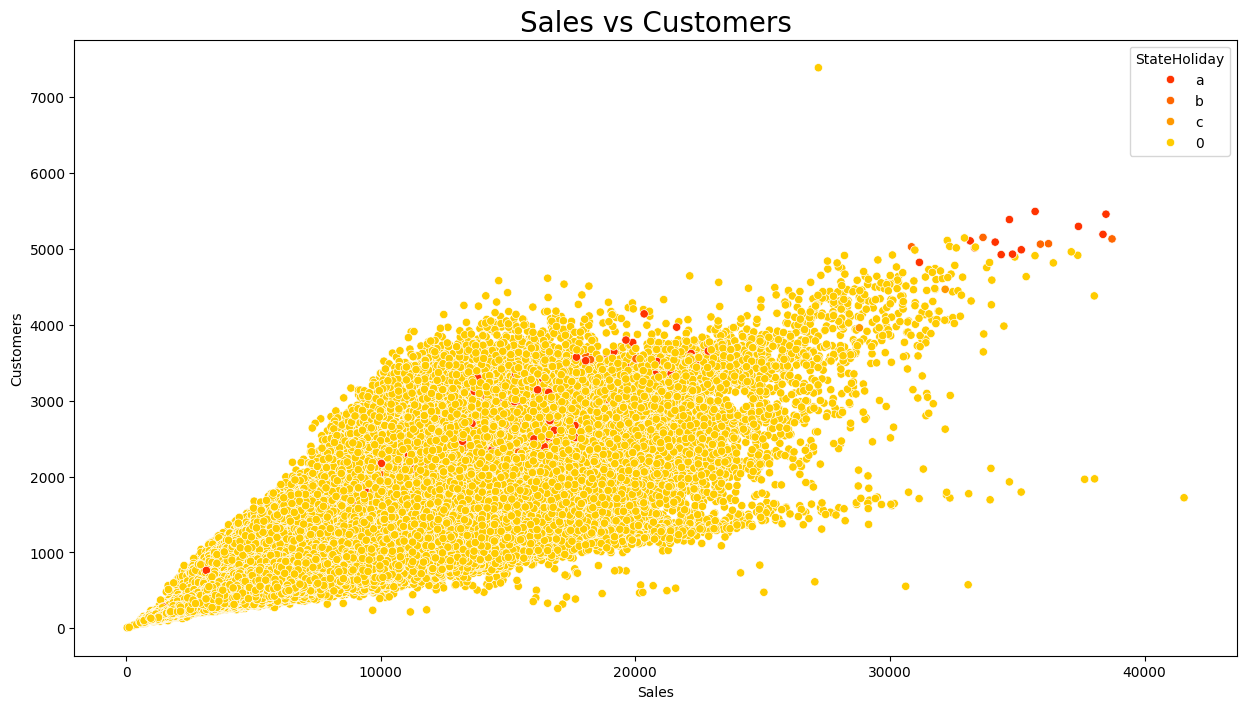

In [27]:
# Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='StateHoliday',palette='autumn',hue_order=['a','b','c','0'])
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

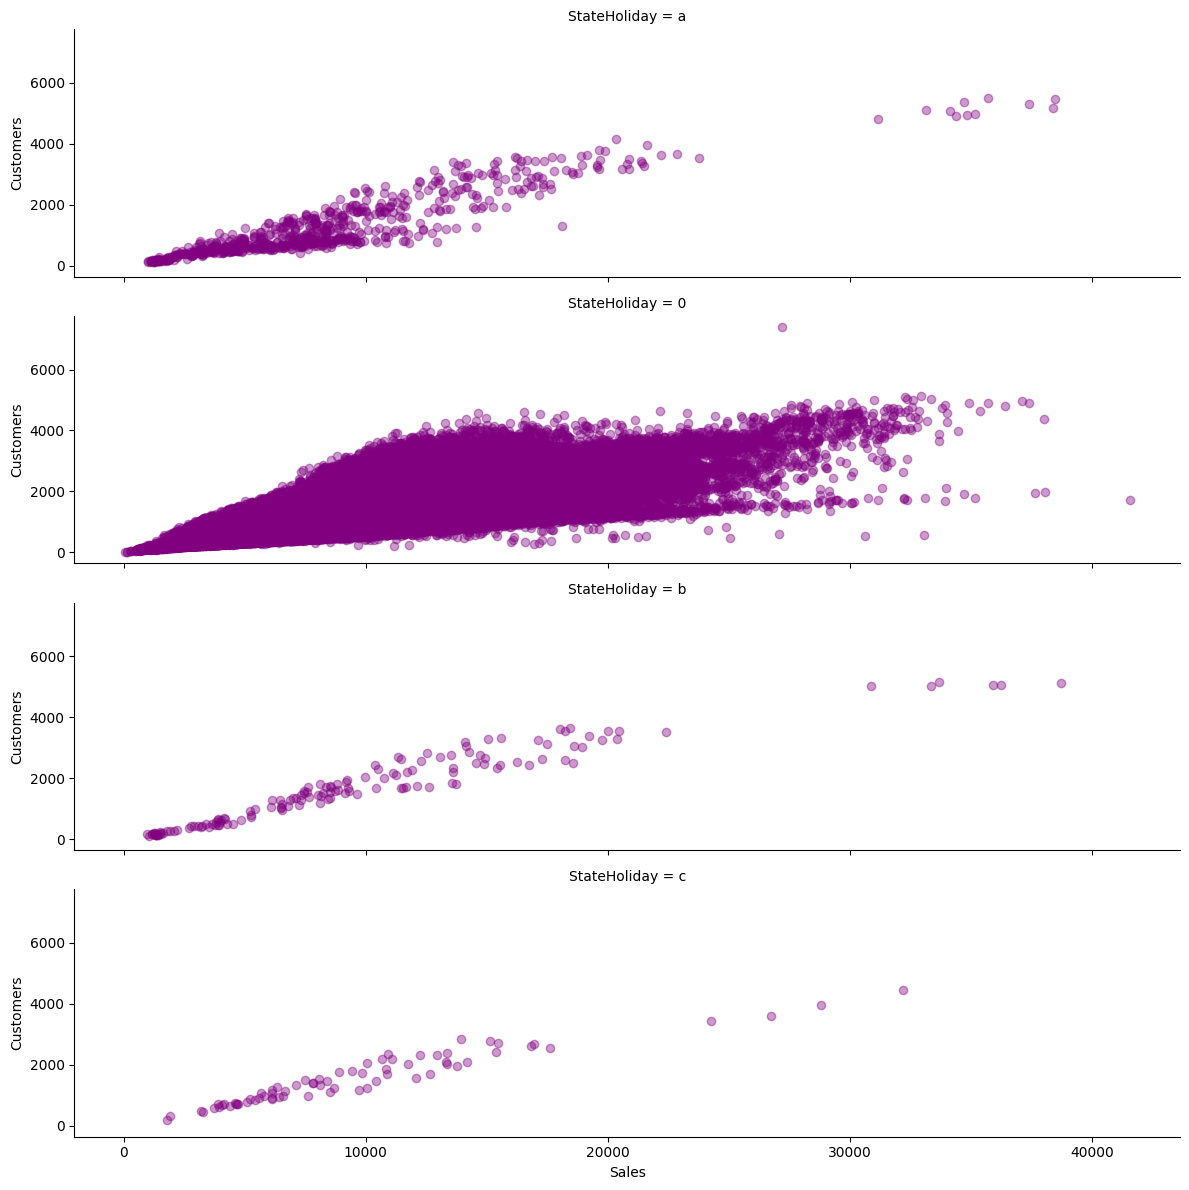

In [28]:
# State Holiday wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='StateHoliday',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='purple',alpha=0.4)
plt.show()

<ipython-input-29-5d0438b905f7>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




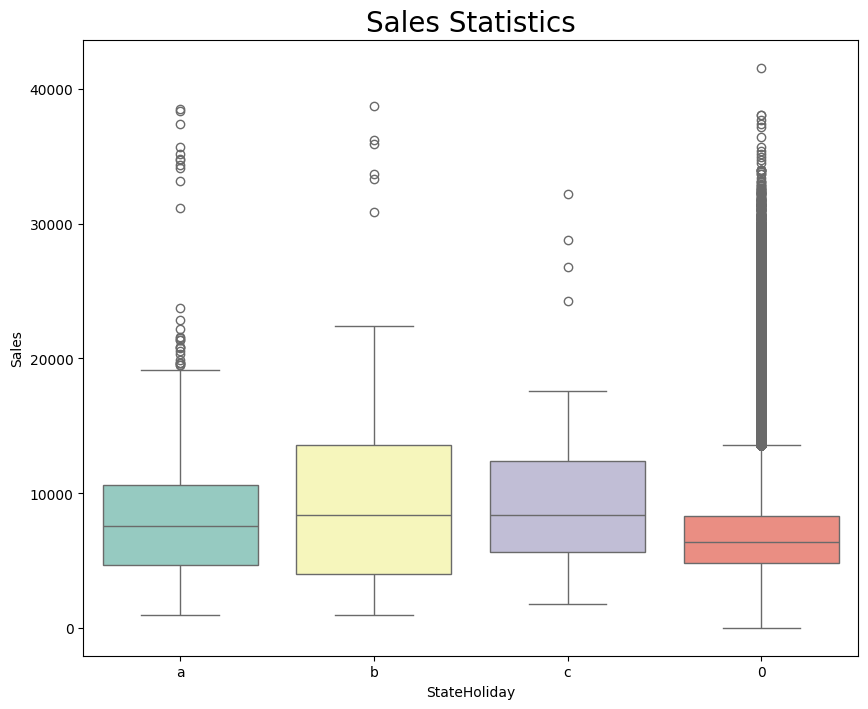

In [29]:
# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='StateHoliday',data=train,order=['a','b','c','0'],palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

<ipython-input-30-02d0e6c8dfd5>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




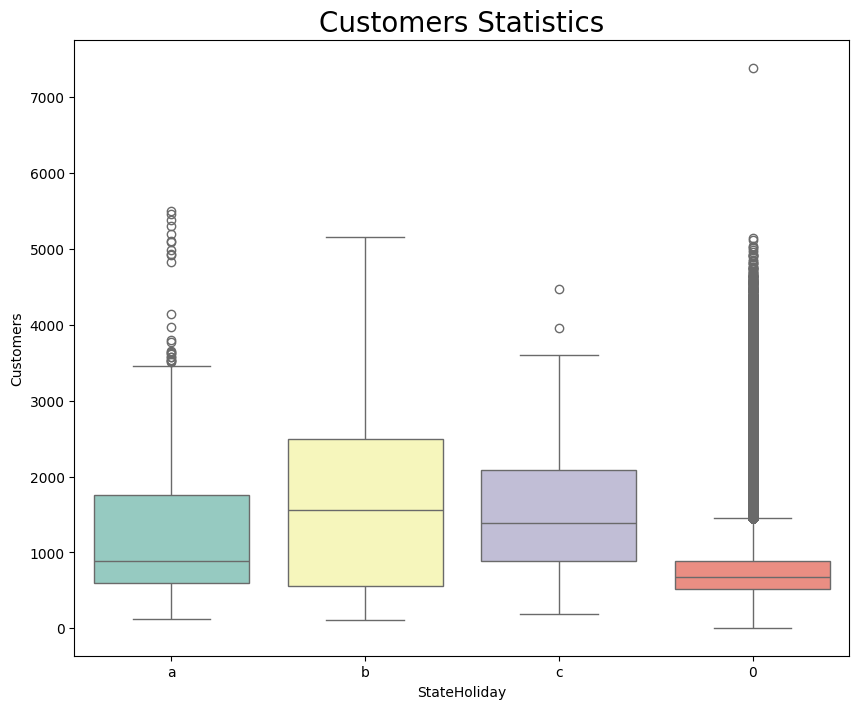

In [30]:
# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='StateHoliday',data=train,order=['a','b','c','0'],palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* People are more often to buy more on Christmas and Easter festival, therefore sales and count of customers visit are more on this seasons
* But it is clearly seen the variation in public choice is less in these festival as people tend to buy particular range and type of product,where as the opposite behavior is been observed when there is no holiday

### 1.4 Visualization based on School Holidays

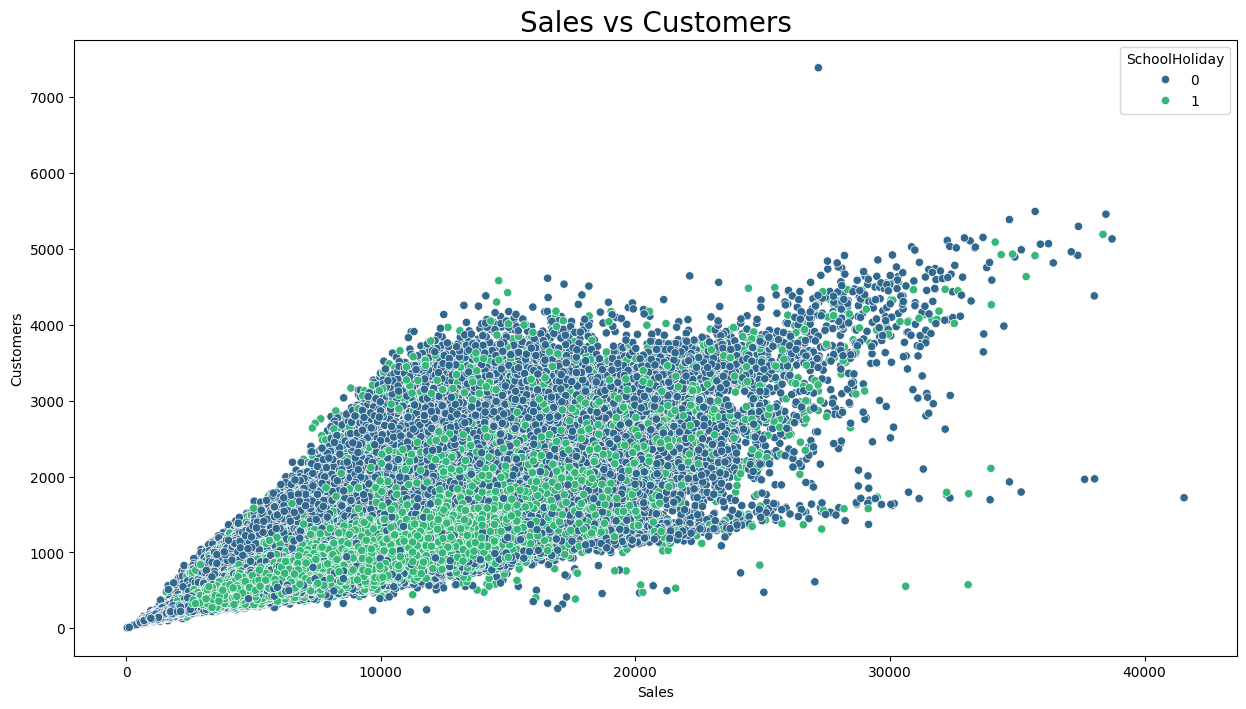

In [31]:
# Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='SchoolHoliday',palette='viridis')
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

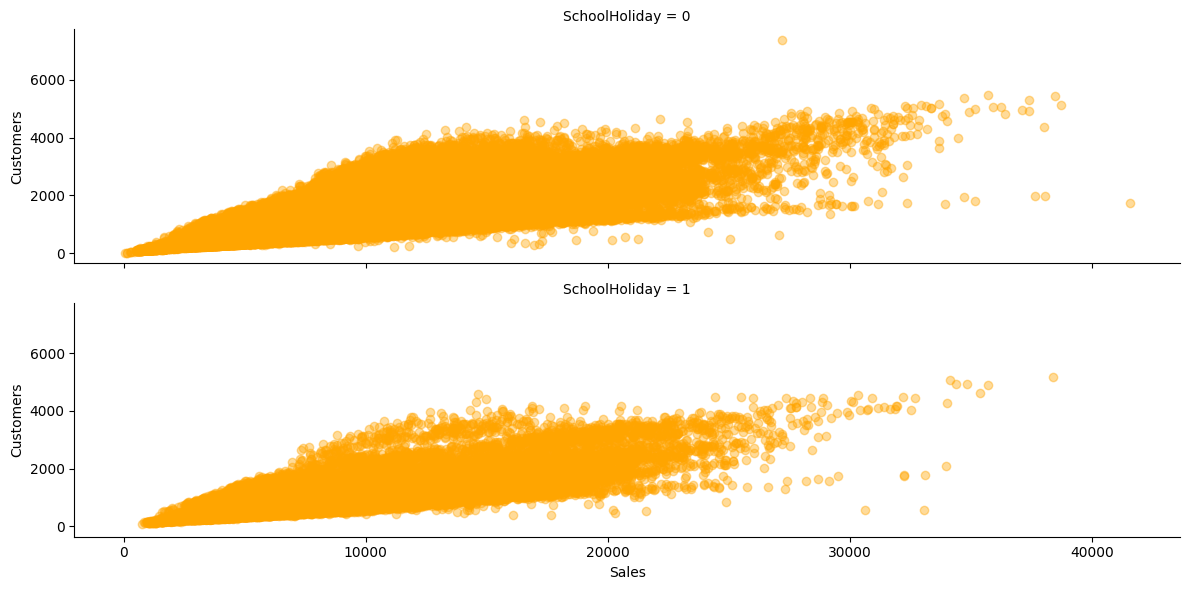

In [32]:
# State Holiday wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='SchoolHoliday',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='orange',alpha=0.4)
plt.show()

<ipython-input-33-1afb47cfac2d>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




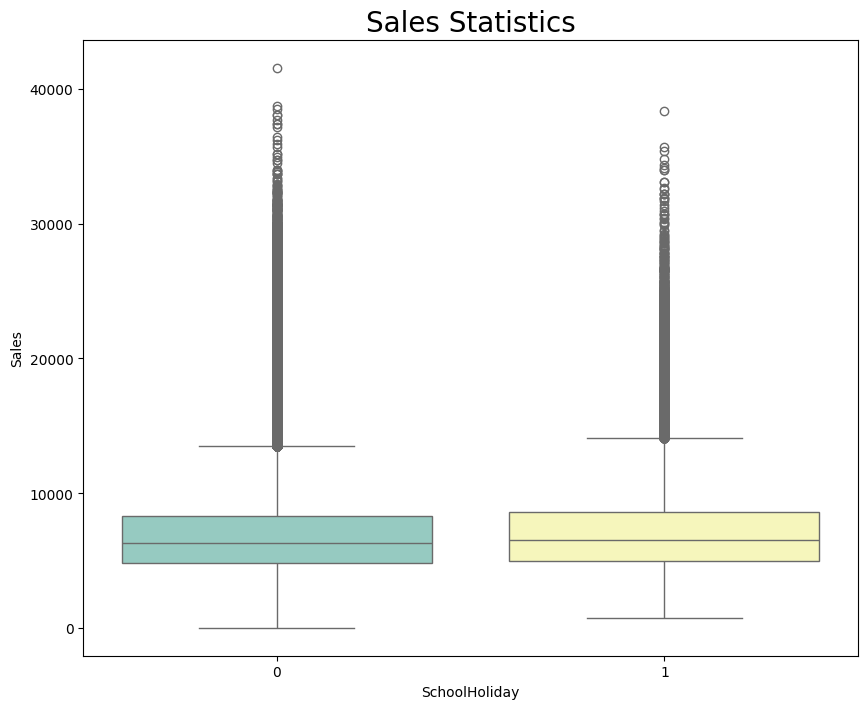

In [33]:
# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='SchoolHoliday',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

<ipython-input-34-9f2ea66a8e60>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




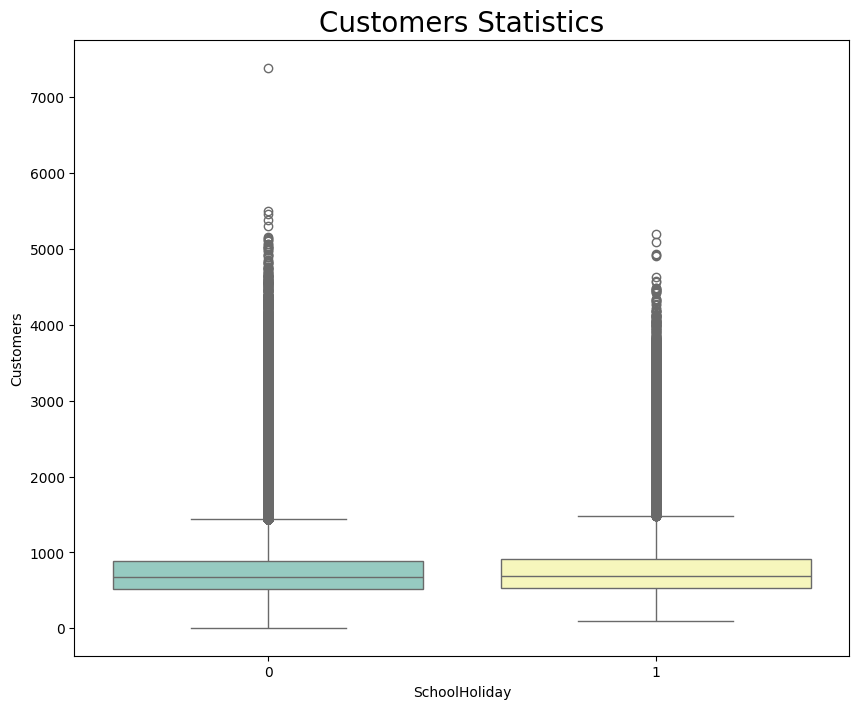

In [34]:
# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='SchoolHoliday',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* Not much difference is observed by the closure of public schools

# 2. Feature Engineering

In [35]:
# Making new column of sales per customers
train['SalesPerCustomer']=train['Sales']/train['Customers']
train['SalesPerCustomer']

0         4
1         7
2         5
3         6
4         4
         ..
844333   11
844334   14
844335   13
844336   10
844337    9
Name: SalesPerCustomer, Length: 844338, dtype: float64



```
# This is formatted as code
```

## 2.1 Average sales, average number of customers and average sales per customers based on weekdays and whether the promo is running on that day.

* No promo was runned on weekends.
* The average sales and average number of customers on weekdays while running promo is high than not running promo.
* The average sale on sunday is quite high than some of the weekdays and the average number of customers is the highest on sunday.
* The average sale per customer is also high on days when promo was runned but the weekends is showing low sales rate. This means people are not buying even though they are capable of as it is evident in the weekdays.
* Should capture the profit potential seen on weekends by running Promos on weekends

* As early said Christman and Easter festival season shows high rate of sales

In [36]:
# Checking the columns of store dataset
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


* There are lots of column having null values
* Some columns are not having right format data, so need to take care of it

In [37]:
# Converting Promo2 column data from integer to category type
store['Promo2']=store['Promo2'].astype(object)
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                        object
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [38]:
# Checking the unique values of category columns
for i in store.columns[store.dtypes=='object']:
    print(i,':',store[i].unique(),'\n')

StoreType : ['c' 'a' 'd' 'b'] 

Assortment : ['a' 'c' 'b'] 

Promo2 : [0 1] 

PromoInterval : [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec'] 



* Dataset is pretty much clear

## 2.2 Creating Dataframe - "avg_store" and merging with store dataset for further analysis

In [39]:
pd.options.display.float_format='{:.3f}'.format # in order to show number upto 3 decimal place

# avg_store Dataframe containing columns : 'Average Sales','Average Customers','Average Sales Per Customer'
avg_store=train.groupby('Store')[['Sales','Customers','SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x : 'Avg_' + x,inplace=True)
avg_store.reset_index(inplace=True)

# Adding column Max_Customers(containing maximum value of customers) to avg_store Dataframe
Max_customer=train.groupby('Store')['Customers'].max()
avg_store=pd.merge(avg_store,Max_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Max_Customers'},inplace=True)

# Adding column Min_Customers(containing mimimum value of customers) to avg_store Dataframe
Min_customer=train.groupby('Store')['Customers'].min()
avg_store=pd.merge(avg_store,Min_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Min_Customers'},inplace=True)

# Adding column Std_Customers(containing Standard Deviation value of customers) to avg_store Dataframe
Std_customer=train.groupby('Store')['Customers'].std()
avg_store=pd.merge(avg_store,Std_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Std_Customers'},inplace=True)

# Adding column Med_Customers(containing Median value of customers) to avg_store Dataframe
Med_customer=train.groupby('Store')['Customers'].median()
avg_store=pd.merge(avg_store,Med_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Med_Customers'},inplace=True)

avg_store.head()

# In order to capture all the variability of customer columns, these much columns are made

Store  Avg_Sales  Avg_Customers  Avg_SalesPerCustomer  Max_Customers  \
0      1   4759.096        564.050                 8.393           1130   
1      2   4953.901        583.999                 8.408           1164   
2      3   6942.569        750.077                 9.118           1579   
3      4   9638.402       1321.753                 7.250           2216   
4      5   4676.275        537.340                 8.611           1081   

   Min_Customers  Std_Customers  Med_Customers  
0            298         93.707        550.000  
1            230        155.374        575.500  
2            381        170.280        744.000  
3            856        198.348       1301.500  
4            180        165.605        564.000

In [40]:
# Merging avg_store with store
store=pd.merge(store,avg_store,how='inner',on='Store')
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a             1270.000                      9.000   
1      2         a          a              570.000                     11.000   
2      3         a          a            14130.000                     12.000   
3      4         c          c              620.000                      9.000   
4      5         a          a            29910.000                      4.000   

   CompetitionOpenSinceYear Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                  2008.000      0              NaN              NaN   
1                  2007.000      1           13.000         2010.000   
2                  2006.000      1           14.000         2011.000   
3                  2009.000      0              NaN              NaN   
4                  2015.000      0              NaN              NaN   

     PromoInterval  Avg_Sales  Avg_Customers  Avg_SalesPerCustomer  \
0              NaN   4759.096        564.050                 8.393   
1  Jan,Apr,Jul,Oct   4953.901        583.999                 8.408   
2  Jan,Apr,Jul,Oct   6942.569        750.077                 9.118   
3              NaN   9638.402       1321.753                 7.250   
4              NaN   4676.275        537.340                 8.611   

   Max_Customers  Min_Customers  Std_Customers  Med_Customers  
0           1130            298         93.707        550.000  
1           1164            230        155.374        575.500  
2           1579            381        170.280        744.000  
3           2216            856        198.348       1301.500  
4           1081            180        165.605        564.000

In [41]:
# Removing missing values in CompetitionDistance column
index=store[store['CompetitionDistance'].isnull()].index
store.loc[index,'CompetitionDistance']=0
store['CompetitionDistance'].isnull().any() # for checking

False

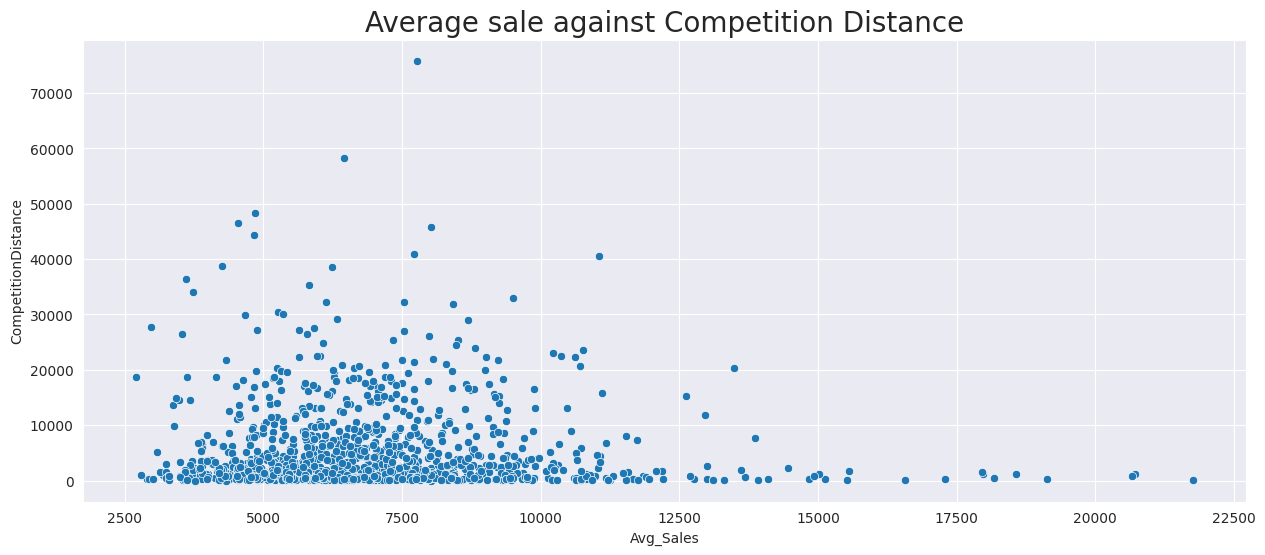

<ipython-input-42-a143adb179b7>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




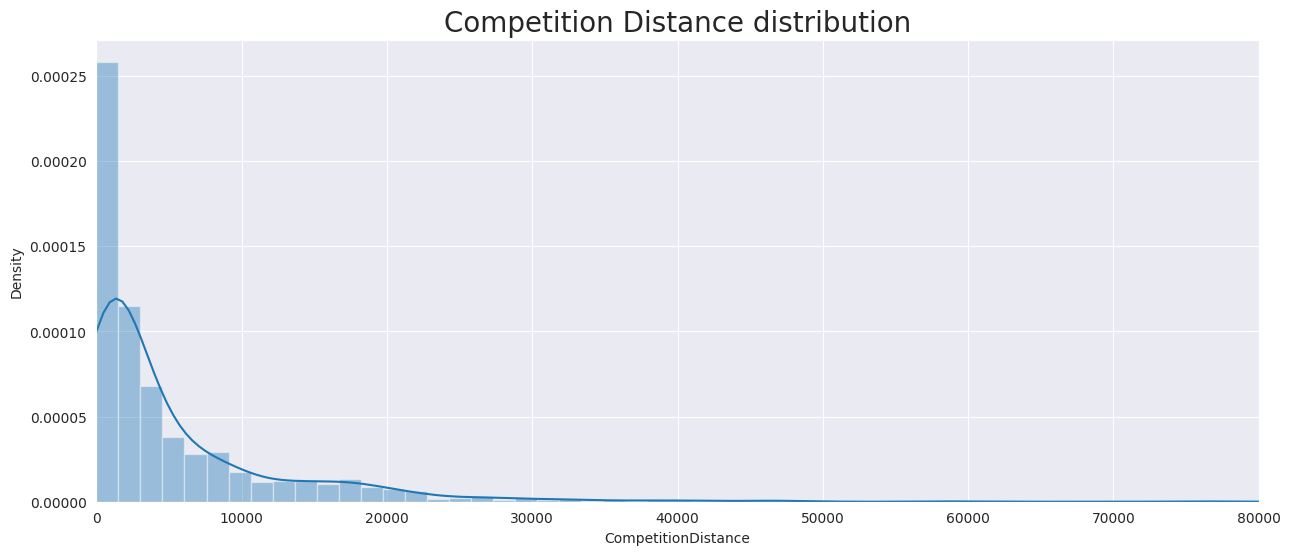

In [42]:
# Scatter plot - Average sale against Competition Distance
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')
sns.scatterplot(x='Avg_Sales',y='CompetitionDistance',data=store)
plt.title('Average sale against Competition Distance',fontdict={'fontsize':20})
plt.show()

# Visualization of Competition Distance data
plt.figure(figsize=(15,6))
sns.distplot(store['CompetitionDistance'])
plt.title('Competition Distance distribution',fontdict={'fontsize':20})
plt.xlim(0,80000)
plt.show()

* It seens there are less competitor's store near to Rossman's store
* Even though many competitor's are near to Rossman's store, the sale is far good enough to beat the compoetition. May be this is because good service quality, better behaviour towards customers and last but not least is the quality of product.

In [43]:
# unique value check

print('CompetitionOpenSinceMonth :',store['CompetitionOpenSinceMonth'].unique(),'\n')

print('CompetitionOpenSinceYear :',store['CompetitionOpenSinceYear'].unique(),'\n')

print('Promo2SinceWeek :',store['Promo2SinceWeek'].unique(),'\n')

print('Promo2SinceYear :',store['Promo2SinceYear'].unique())

CompetitionOpenSinceMonth : [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.] 

CompetitionOpenSinceYear : [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.] 

Promo2SinceWeek : [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.] 

Promo2SinceYear : [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]


In [44]:
# Getting free from missing values

index=store[(store['CompetitionOpenSinceMonth'].isnull())&(store['CompetitionOpenSinceYear'].isnull())].index
store.loc[index,['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]=0

index=store[(store['Promo2SinceWeek'].isnull())&(store['Promo2SinceYear'].isnull())&(store['Promo2']==0)].index
store.loc[index,['Promo2SinceWeek','Promo2SinceYear']]=0

store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']].isnull().any() # To check

CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2SinceWeek              False
Promo2SinceYear              False
dtype: bool

In [45]:
# Converting from float into integer type
store[['CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear',
       'Promo2SinceWeek',
       'Promo2SinceYear']]=store[['CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear',
                                  'Promo2SinceWeek',
                                  'Promo2SinceYear']].astype(int)

store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']].dtypes # To check

CompetitionOpenSinceMonth    int64
CompetitionOpenSinceYear     int64
Promo2SinceWeek              int64
Promo2SinceYear              int64
dtype: object

In [46]:
# Setting Promo Interval equal to zero for those who are not continuing Promo and for missing values
index=store[(store['Promo2']==0)&(store['PromoInterval'].isnull().any())].index
store.loc[index,'PromoInterval']=0

store['PromoInterval'].isnull().any() # To check

False

In [47]:
# Last check in columns of store
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int64  
 5   CompetitionOpenSinceYear   1115 non-null   int64  
 6   Promo2                     1115 non-null   object 
 7   Promo2SinceWeek            1115 non-null   int64  
 8   Promo2SinceYear            1115 non-null   int64  
 9   PromoInterval              1115 non-null   object 
 10  Avg_Sales                  1115 non-null   float64
 11  Avg_Customers              1115 non-null   float64
 12  Avg_SalesPerCustomer       1115 non-null   float64
 13  Max_Customers              1115 non-null   int64

* The data is clean and free from missing values

## 2.3 Visualization based on Store type

<Figure size 1500x800 with 0 Axes>

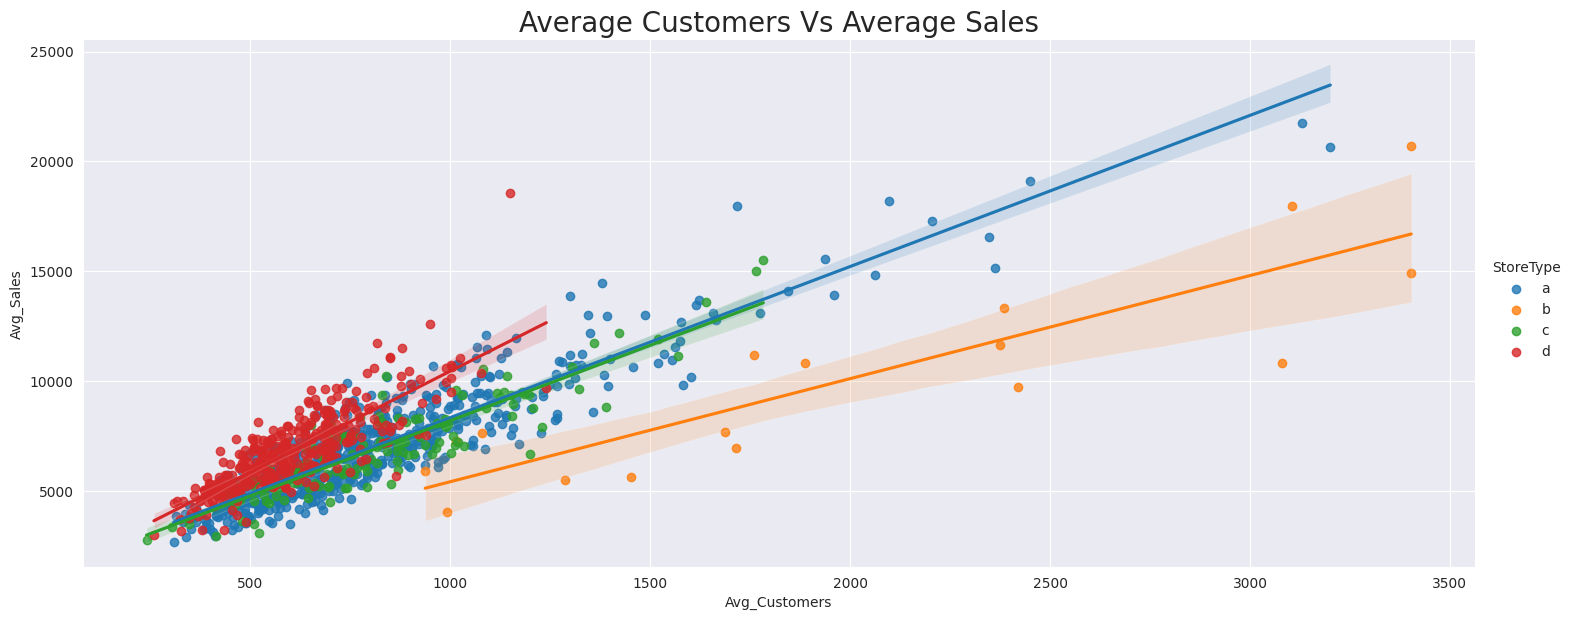

<ipython-input-48-54ebea448748>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




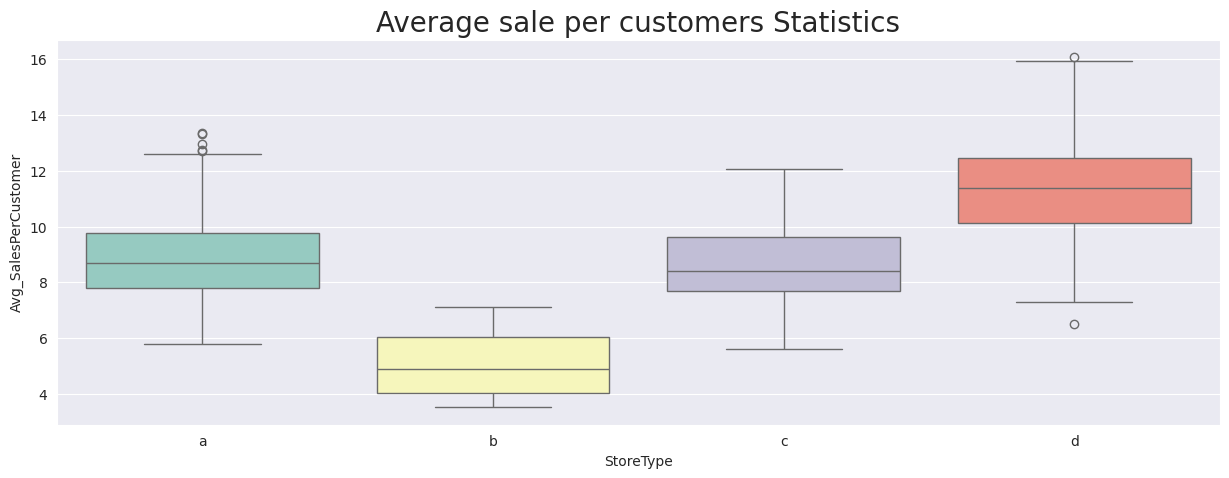

In [48]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='StoreType',data=store,hue_order=['a','b','c','d'],height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='StoreType',y='Avg_SalesPerCustomer',data=store,order=['a','b','c','d'],palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

* Store type d is having much higher sale but the variability is very less as people are buying one particular set of products
* Store type a and c are same sales but both are less than d type
* The least one is b type store and its shows large variability. May be this type of store is located in rural or suburban area
* As expected the sales rate of d type is higher than a and c type and b type have very less sales rate

## 2.4 Visualization based on Assortment

<Figure size 1500x800 with 0 Axes>

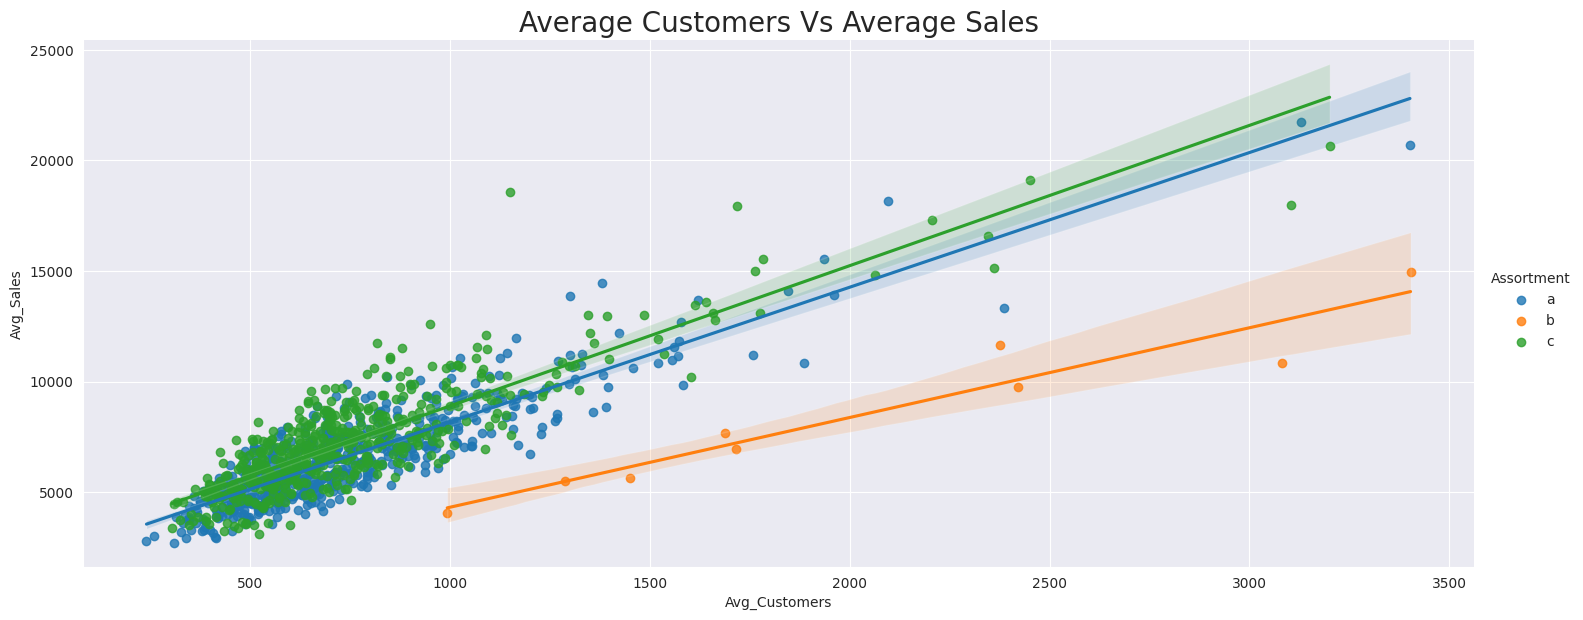

<ipython-input-49-37edc2d3072a>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




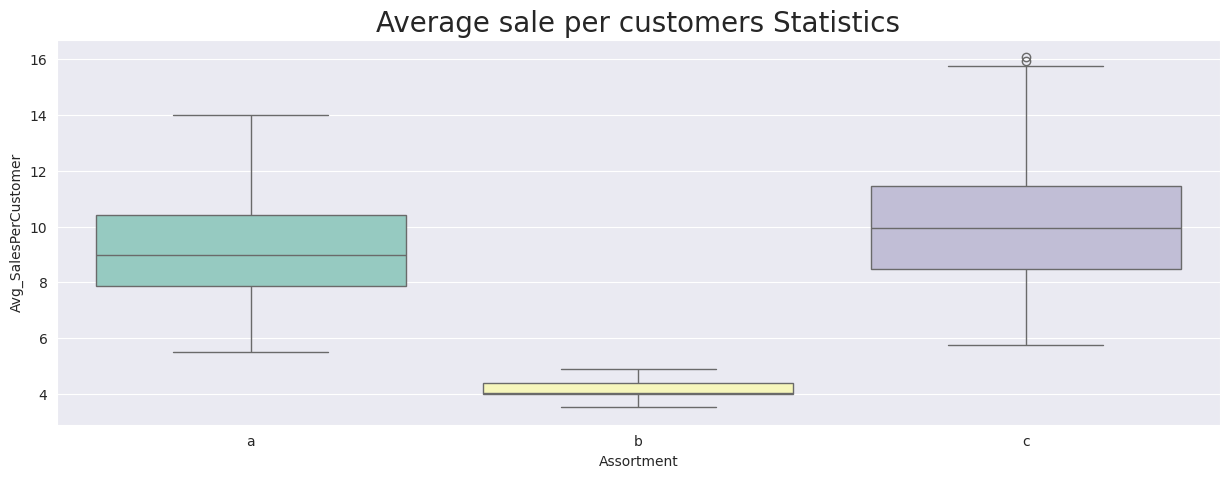

In [49]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='Assortment',data=store,hue_order=['a','b','c'],height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='Assortment',y='Avg_SalesPerCustomer',data=store,order=['a','b','c'],palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

* It is quite interesting to observe that the line of assortment type a and c are almost parallel, ie. both are having the same average number of customers but the sales are higher in type c
* Also the sales rate is highest in type c

## 2.5 Visualization based on whether the Promo is continuing

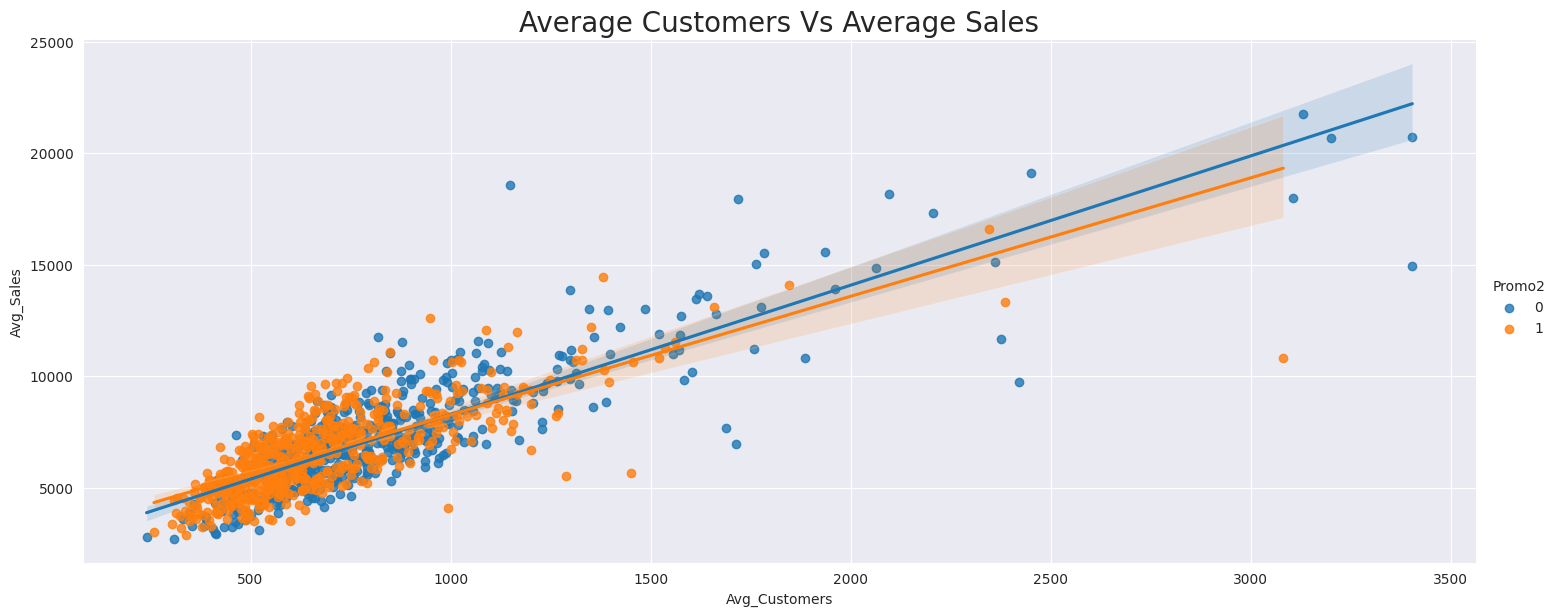

<ipython-input-50-b8c0b7045bd9>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




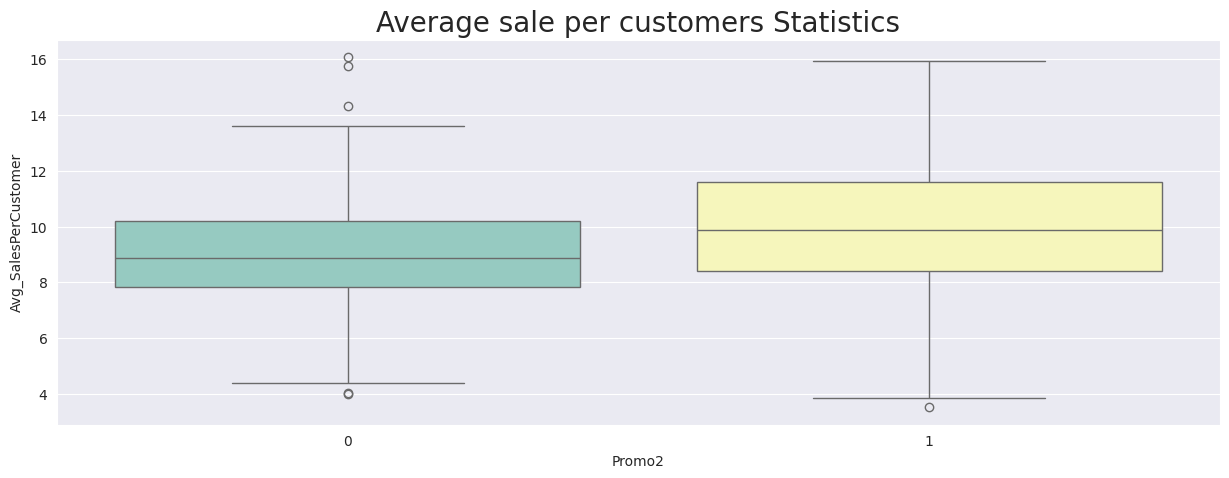

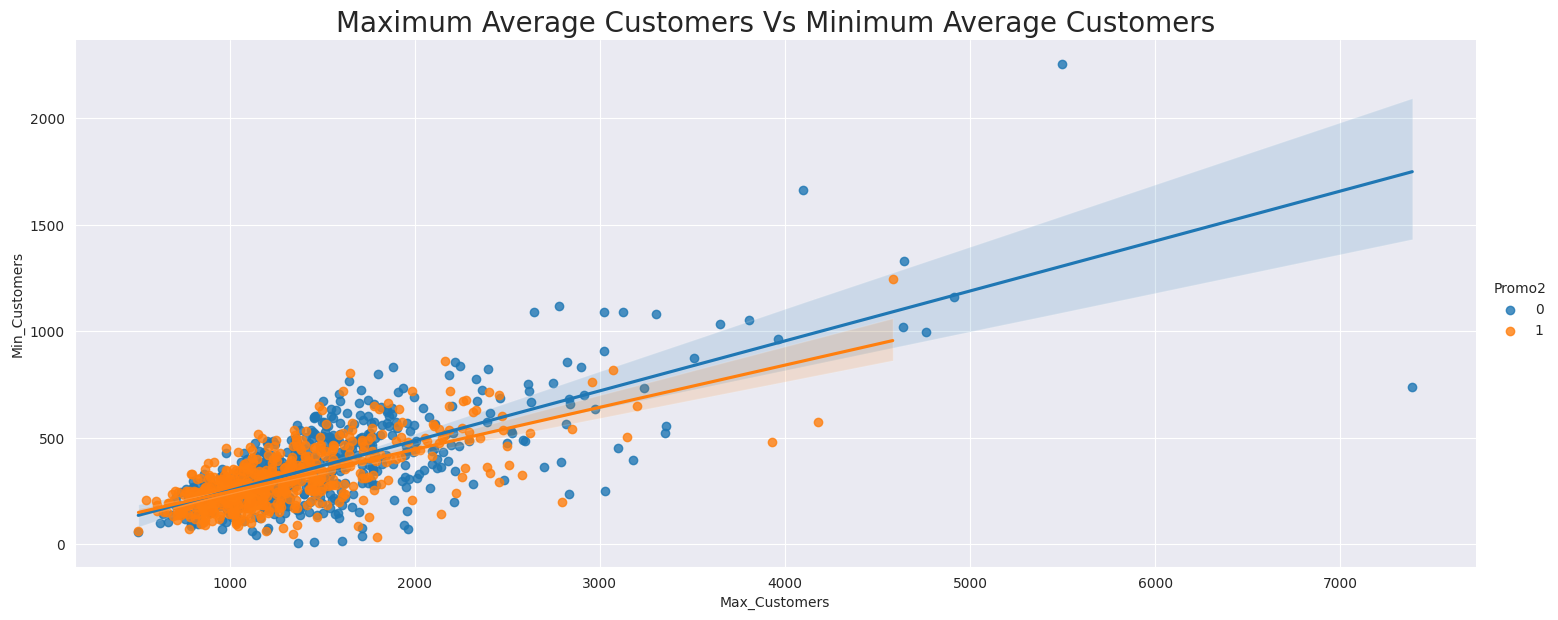

In [50]:
# scatter plot - Average Customers against Average Sales
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='Promo2',data=store,height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='Promo2',y='Avg_SalesPerCustomer',data=store,palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

# scatter plot - Maximum Average Customers against Minimum Average Customers
sns.lmplot(x='Max_Customers',y='Min_Customers',hue='Promo2',data=store,height=6,aspect=2.5)
plt.title('Maximum Average Customers Vs Minimum Average Customers', fontdict={'fontsize':20})
plt.show()

* In the first figure : the line at the begining overlaps each other but as its moves further it diverge from each other with 0 assigned line showing more sales for the same number of customers
* The box plot shows the sales rate is high for those store who are continuing the promo but the difference is narrow
* In the last figure : there is still divergence in line and the mimimum number of customers is less for the 1 assigned line as compare to 0 assigned one
* this indicates the continuing of advertisements and promo is not a good idea as people are getting bored with the same promo.

## 2.6 Visualization based on Promo Interval

<Figure size 1500x800 with 0 Axes>

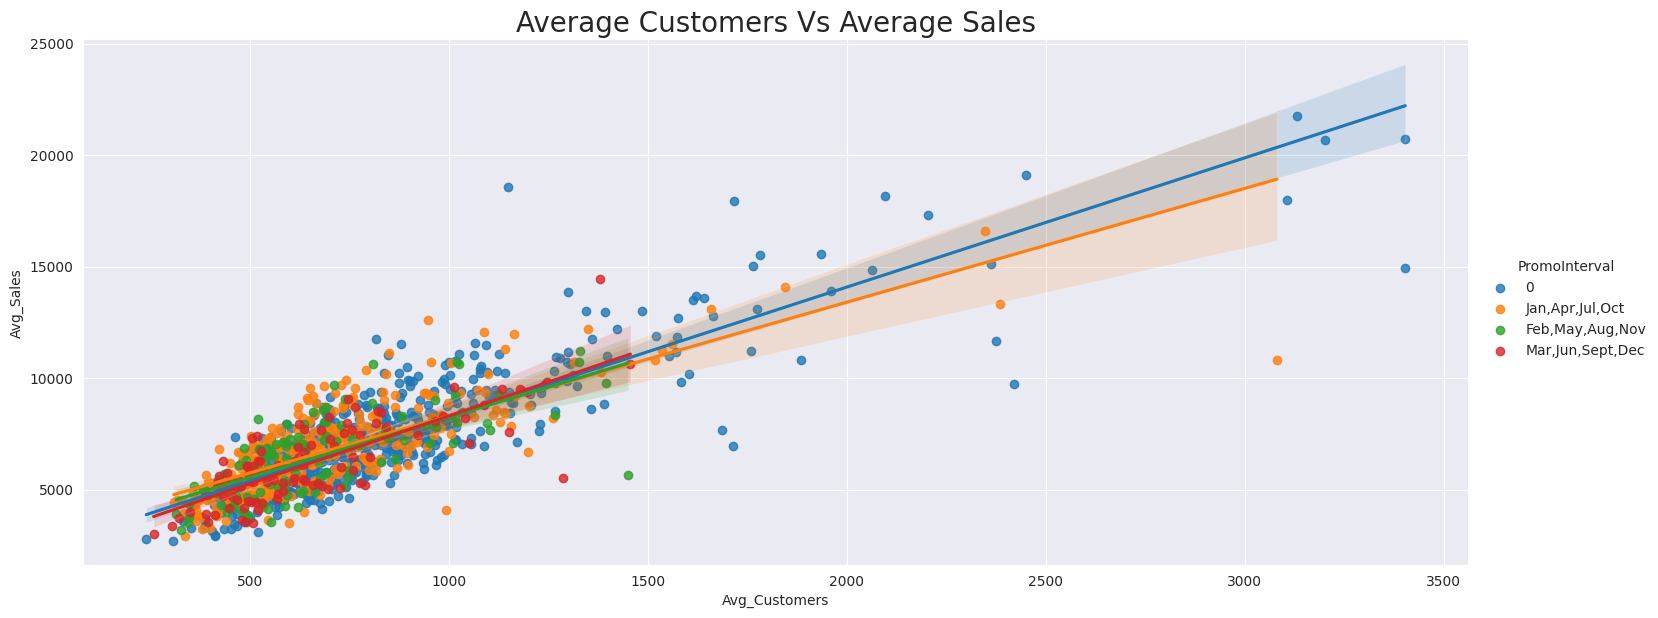

<ipython-input-51-84a968ea75e2>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




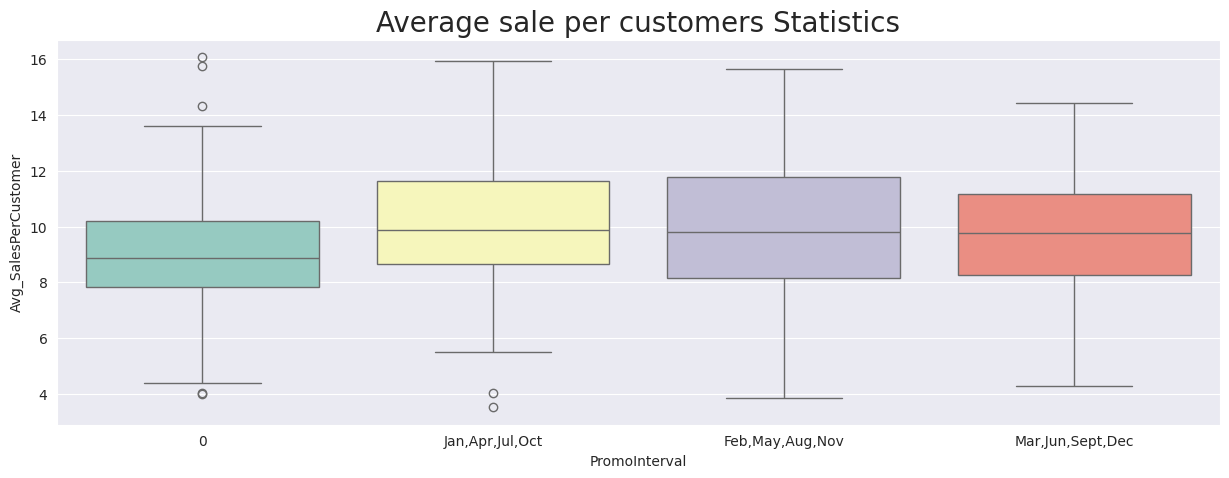

In [51]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='PromoInterval',data=store,height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='PromoInterval',y='Avg_SalesPerCustomer',data=store,palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

* The sales rate are almost same

* From the above table as well as figures it is clear that continuing promo is not helping the business, it does not matter on which month the promo was runned .
* The b type store is most effected as sales rate is lowest

## 2.7 Merging train and store dataset to form new train dataset containing all the attributes

In [52]:
# Merging
new_train=pd.merge(train,store,how='left',on='Store')
print('New training dataset shape :',new_train.shape)
new_train.head()

New training dataset shape : (844338, 25)


Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0   1097          2 2013-01-01   5961       1405      0            a   
1     85          2 2013-01-01   4220        619      0            a   
2    259          2 2013-01-01   6851       1444      0            a   
3    262          2 2013-01-01  17267       2875      0            a   
4    274          2 2013-01-01   3102        729      0            a   

   SchoolHoliday  SalesPerCustomer StoreType  ... Promo2SinceWeek  \
0              1             4.243         b  ...               0   
1              1             6.817         b  ...               0   
2              1             4.744         b  ...               0   
3              1             6.006         b  ...               0   
4              1             4.255         b  ...              10   

   Promo2SinceYear    PromoInterval  Avg_Sales Avg_Customers  \
0                0                0   9744.600      2420.921   
1                0                0   7272.454      1015.401   
2                0                0  11656.145      2374.844   
3                0                0  20718.516      3402.011   
4             2013  Jan,Apr,Jul,Oct   4070.828       992.741   

   Avg_SalesPerCustomer  Max_Customers Min_Customers  Std_Customers  \
0                 4.015           3804          1055        329.306   
1                 7.120           1992           433        286.779   
2                 4.884           3648          1033        370.452   
3                 6.057           5494          2255        580.749   
4                 4.035           1962           480        247.459   

   Med_Customers  
0       2460.000  
1        929.500  
2       2418.000  
3       3239.000  
4        926.000  

[5 rows x 25 columns]

In [53]:
# Making new columns to show Date information separately
new_train['Year']=new_train['Date'].dt.year
new_train['Month']=new_train['Date'].dt.month
new_train['Day']=new_train['Date'].dt.day
new_train['Week']=new_train['Date'].dt.isocalendar().week # Use isocalendar().week to get week number
new_train.head()

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0   1097          2 2013-01-01   5961       1405      0            a   
1     85          2 2013-01-01   4220        619      0            a   
2    259          2 2013-01-01   6851       1444      0            a   
3    262          2 2013-01-01  17267       2875      0            a   
4    274          2 2013-01-01   3102        729      0            a   

   SchoolHoliday  SalesPerCustomer StoreType  ... Avg_Customers  \
0              1             4.243         b  ...      2420.921   
1              1             6.817         b  ...      1015.401   
2              1             4.744         b  ...      2374.844   
3              1             6.006         b  ...      3402.011   
4              1             4.255         b  ...       992.741   

   Avg_SalesPerCustomer  Max_Customers  Min_Customers Std_Customers  \
0                 4.015           3804           1055       329.306   
1                 7.120           1992            433       286.779   
2                 4.884           3648           1033       370.452   
3                 6.057           5494           2255       580.749   
4                 4.035           1962            480       247.459   

   Med_Customers  Year Month  Day  Week  
0       2460.000  2013     1    1     1  
1        929.500  2013     1    1     1  
2       2418.000  2013     1    1     1  
3       3239.000  2013     1    1     1  
4        926.000  2013     1    1     1  

[5 rows x 29 columns]

* 4 new columns were added

In [54]:
# Making column "MonthCompetitionOpen" which contains date information in months since the competition was opened
new_train['MonthCompetitionOpen']=12*(new_train['Year']-new_train['CompetitionOpenSinceYear'])+\
new_train['Month']-new_train['CompetitionOpenSinceMonth']

new_train.loc[(new_train['CompetitionOpenSinceYear']==0),'MonthCompetitionOpen']=0
# Negative values indcate that the competitor's store was opened after the Rossman's store opening date.

In [55]:
# Making column "WeekPromoOpen" which contains date information in weeks since the promo is running
new_train['WeekPromoOpen']=52.14298*(new_train['Year']-new_train['Promo2SinceYear'])+\
new_train['Week']-new_train['Promo2SinceWeek']

new_train.loc[(new_train['Promo2SinceYear']==0),'WeekPromoOpen']=0

## 2.8 Visualization based on Months

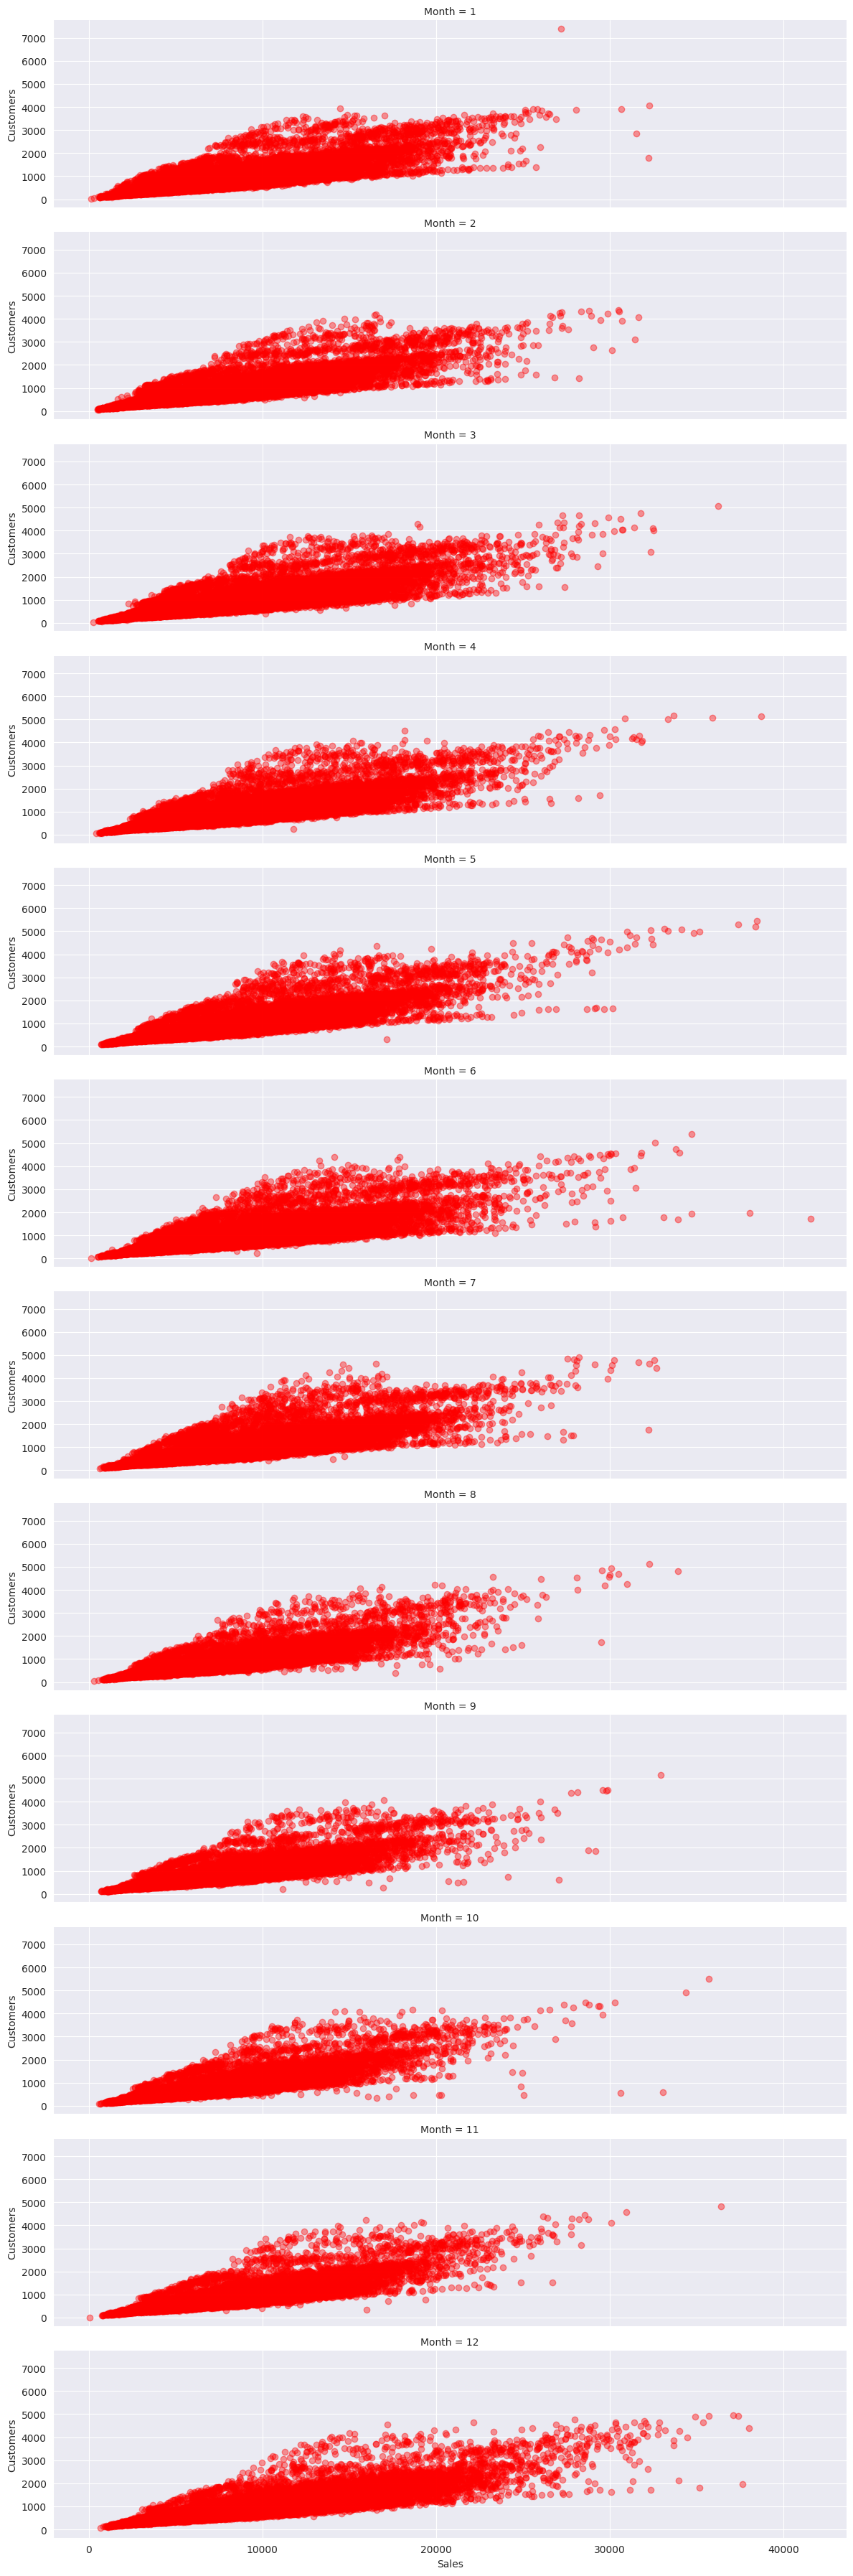

<ipython-input-56-a48ca63abd6c>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




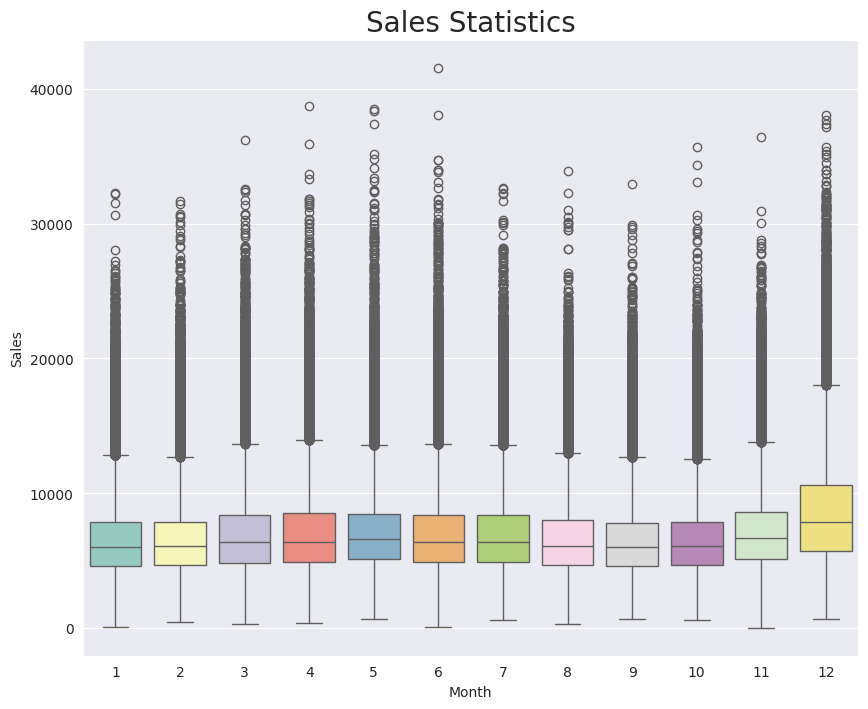

<ipython-input-56-a48ca63abd6c>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




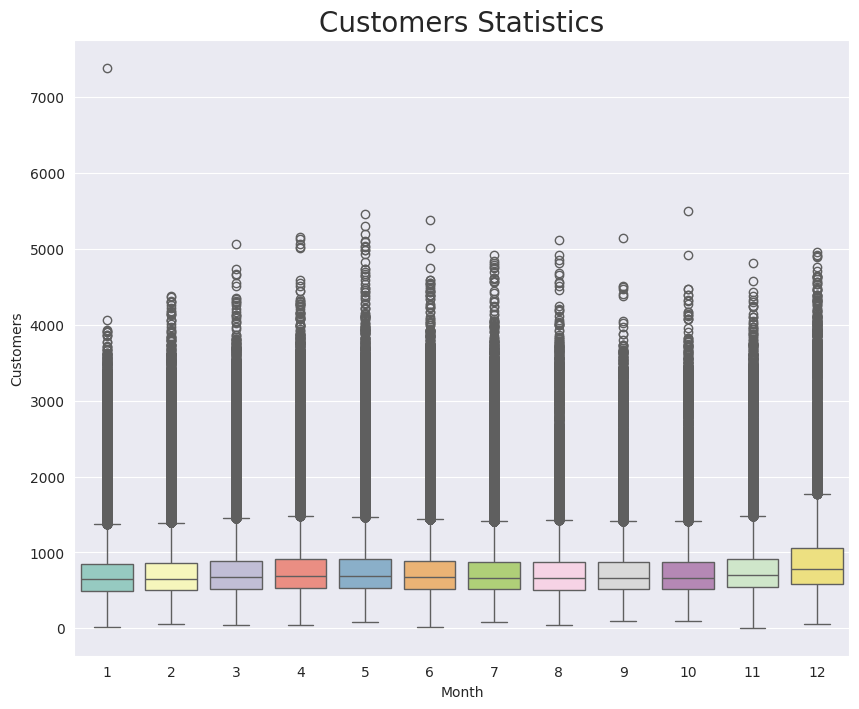

In [56]:
# scatter plot - Sales against Customers
g=sns.FacetGrid(row='Month',data=new_train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='red',alpha=0.4)
plt.show()

# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='Month',data=new_train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='Month',data=new_train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* Now it is obvious that the month of November and December the sale and number of customers would be high
* Sales are also high in the summer season

In [57]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  object        
 7   SchoolHoliday              844338 non-null  int64         
 8   SalesPerCustomer           844338 non-null  float64       
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        844338 non-null  float64 

In [58]:
# converting into integer type
new_train['Promo2']=new_train['Promo2'].astype(int)

In [59]:
"""Droping column customer because we are performing sales prediction and knowing the number of customers on particular store before actual
   sales happen is not possible"""
new_train.drop('Customers',axis=1,inplace=True)

# 3. Building and Implementing Machine Learning Models

## 3.1 Preparing dataset and Normalizing certain column data

In [60]:
# Making a new data set for model building
trainS=new_train[['Store', 'DayOfWeek','Sales','Promo',
       'StateHoliday', 'SchoolHoliday','StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval','Avg_Customers',
       'Max_Customers', 'Min_Customers',
       'Std_Customers', 'Med_Customers', 'Year', 'Month', 'Day', 'Week',
       'MonthCompetitionOpen', 'WeekPromoOpen']]
trainS.shape

(844338, 26)

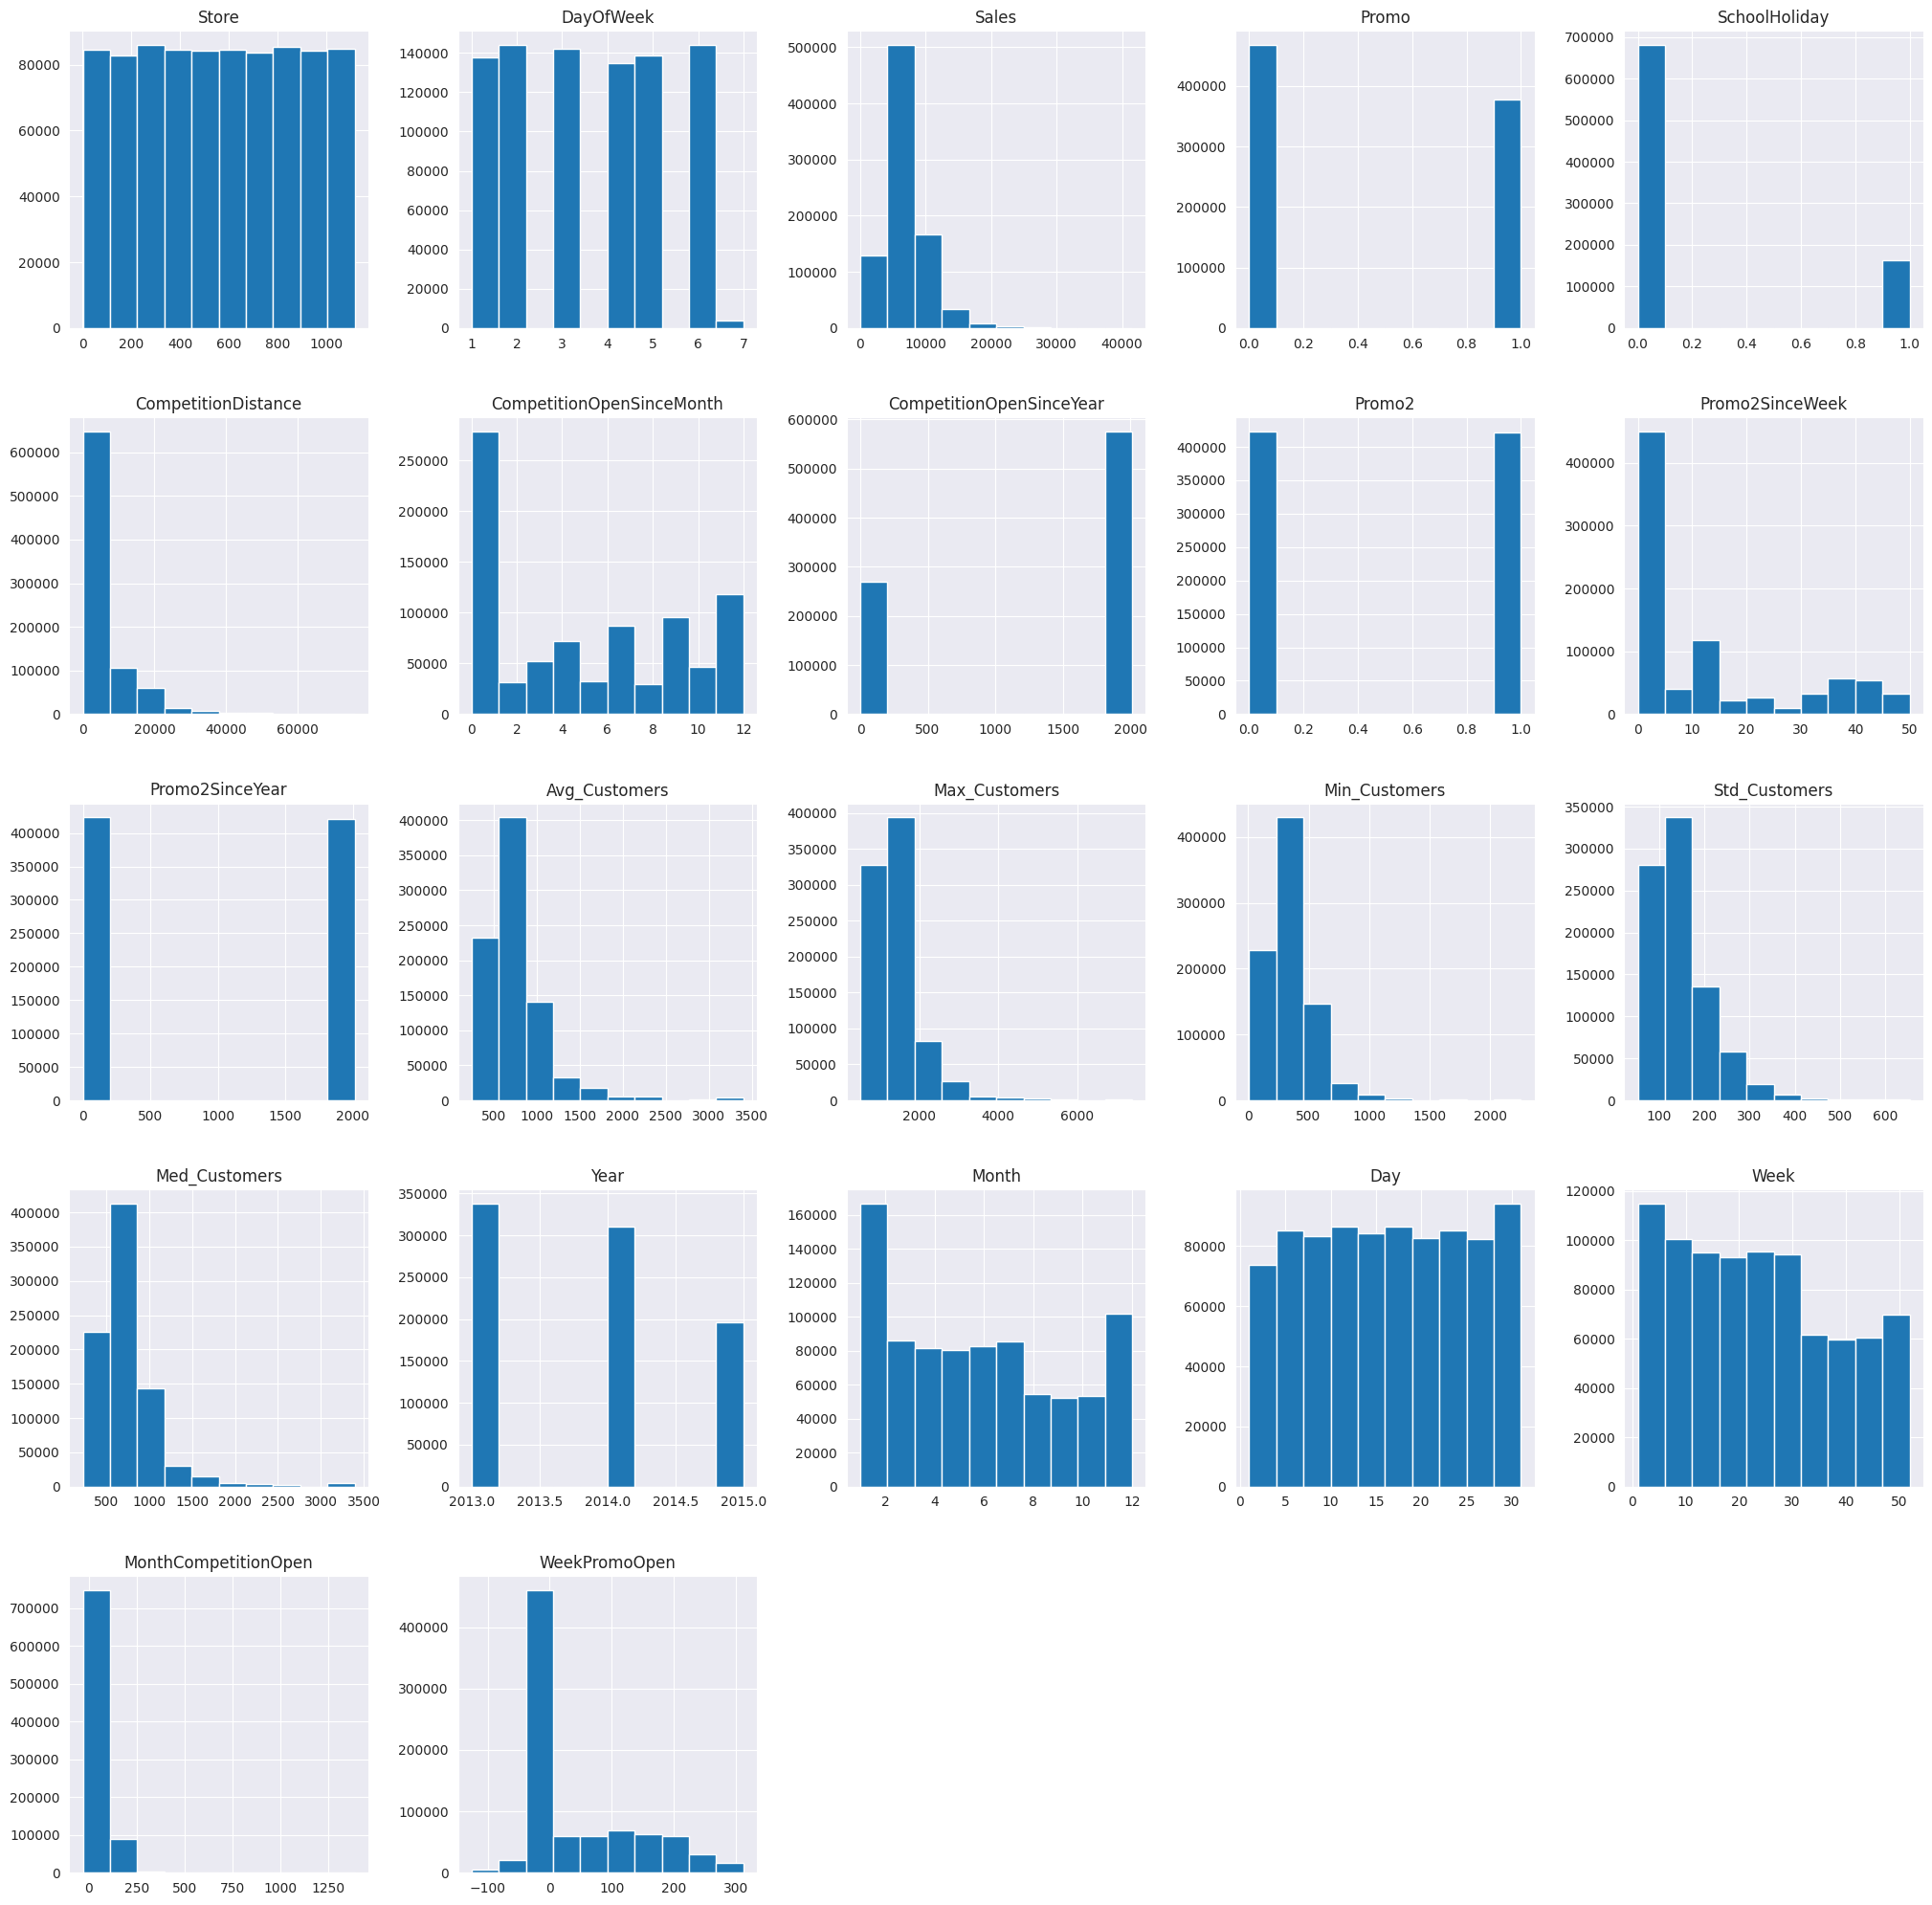

In [61]:
# Visualization to chech whether the data is distributed normally
trainS.hist(figsize=(25,25))
plt.show()

* Some of the columns data are positively skewed, therefore have to deal with it.
* This is not a necessary step but normally distributed data yields better result

<ipython-input-62-5c02acfdd80c>:5: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




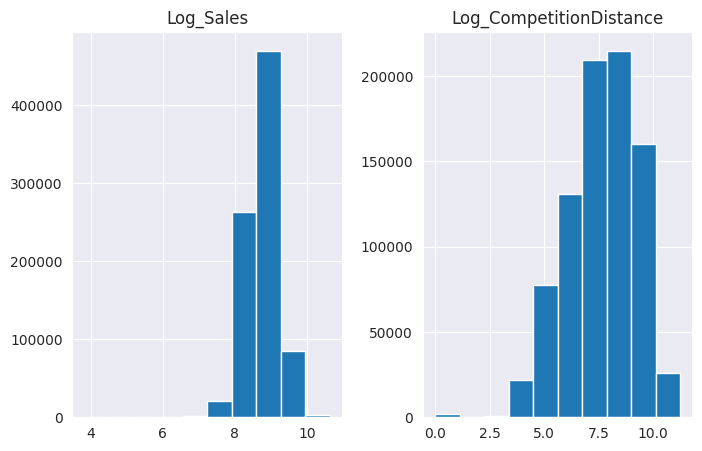

In [62]:
# Taking log transformation
trainS['Log_Sales']=np.log(trainS['Sales'])

index=trainS[trainS['CompetitionDistance']==0].index
trainS['CompetitionDistance'][index]=1
trainS['Log_CompetitionDistance']=np.log(trainS['CompetitionDistance'])

trainS[['Log_Sales','Log_CompetitionDistance',]].hist(figsize=(8,5))
plt.show()

trainS.drop(['Sales','CompetitionDistance'],axis=1,inplace=True)

# Note : This is not a necessary step but doing this will redistribute the data in normal curve which is better for good prediction

* Almost normally distributed

In [63]:
# Getting dummies columns for categorical columns
final_train=pd.get_dummies(data=trainS,columns=['StoreType','StateHoliday','Assortment','PromoInterval'])
final_train.shape

(844338, 37)

## 3.2 Model Building : Random Forest Regressor

### 3.2.1 Spliting the dataset

In [64]:
# Spliting dataset into X and y
X=final_train.drop('Log_Sales',axis=1)
y=final_train['Log_Sales']

# Spliting dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

### 3.2.2 Creating and Training the model

In [65]:
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor(n_estimators=200,
                          criterion='squared_error',
                          max_features='sqrt',
                          oob_score=True,
                          n_jobs=32,
                          verbose=1,
                          random_state=101)

rfr.fit(X_train,y_train)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:  1.6min
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:  2.1min finished


RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=32,
                      oob_score=True, random_state=101, verbose=1)

In [66]:
# Prediction
predict=rfr.predict(X_test)
predict

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    5.7s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    7.8s finished


array([8.62181864, 9.41102365, 9.15250175, ..., 8.51098909, 8.57076454,
       8.97619026])

### 3.2.3 Model Evaluation

An "Out of Bag (OOB) score" is a performance metric used primarily in ensemble learning methods like Random Forests, which estimates the model's accuracy by evaluating its predictions on data points that were not included in the training set for each individual decision tree during the bootstrapping process

In [67]:
# Out of Bag score
print('oob score :',rfr.oob_score_)

oob score : 0.9230616872765686


In [6]:
from sklearn.metrics import mean_squared_error

# Simple MSE calculation
mse = mean_squared_error(np.exp(y_test), np.exp(predict))
print('Mean Square Error: {}'.format(mse))

Mean Square Error: 1.7630520181815


In [7]:
# Root mean square error
from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(np.exp(y_test),np.exp(predict))
print('Root Mean Square Error {}'.format(sqrt(mse)))

Root Mean Square Error: 1.327799


### 3.2.4 Predictions from Model

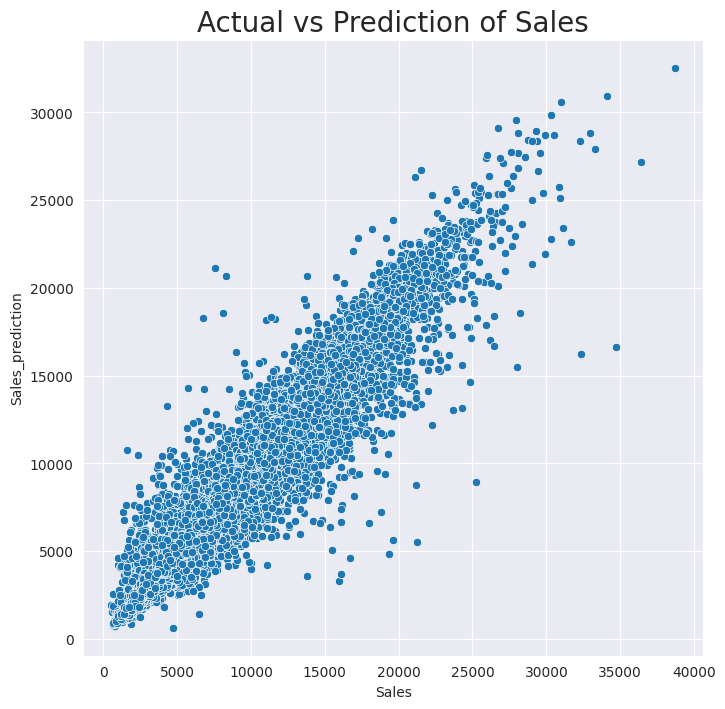

Sales  Sales_prediction
0       4880.000          5551.000
1      11791.000         12222.000
2      10209.000          9438.000
3       4915.000          4932.000
4       6457.000          7626.000
...          ...               ...
126646  7222.000          6640.000
126647 10666.000          8294.000
126648  5990.000          4969.000
126649  6884.000          5275.000
126650  4817.000          7912.000

[126651 rows x 2 columns]

In [70]:
prediction=pd.DataFrame(np.exp(y_test))
prediction['Sales_prediction']=np.exp(predict).round()
prediction.rename(columns={'Log_Sales':'Sales'},inplace=True)

# Visualization
plt.figure(figsize=(8,8))
sns.scatterplot(x='Sales',y='Sales_prediction',data=prediction)
plt.title('Actual vs Prediction of Sales',fontdict={'fontsize':20})
plt.show()

prediction.reset_index(inplace=True)
prediction.drop('index',axis=1,inplace=True)
prediction

### **Business Questions**

1. How accurately can the model predict daily demand for various perishable items across different seasons?

2. What is the estimated reduction in costs associated with unsold perishable goods after implementing the demand forecasting model?

3. How much reduction in food waste can supermarkets achieve, and what is the environmental impact in terms of reduced resource usage?

4. Will optimized inventory levels lead to an increase in overall sales by minimizing instances of stockouts?

5. How does the model account for the impact of promotions on demand, and how can this data help in planning more effective promotional strategies?

6. How can supermarkets use weather and holiday data to adjust inventory in specific regions or seasons to minimize waste?

7. Can the optimized inventory system improve customer satisfaction by ensuring availability of fresh products?

8. What are the implementation costs for this system, and how does it compare to the long-term savings in reduced waste and improved sales?




Total Answered 6 business questions